<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

In [4]:
# Базовые библиотеки
import pandas as pd  # Импортируем библиотеку для работы с данными в формате DataFrame
import numpy as np   # Используем для операций с числами и массивами
import matplotlib.pyplot as plt  # Подключаем для построения графиков

# Дополнительные модули
import warnings   # Для управления предупреждениями
from tqdm import tqdm  # Добавляет индикатор выполнения для циклов
from IPython.display import display, Image  # Для отображения изображений или HTML

# Модели обучения
from sklearn.linear_model import LinearRegression  # Линейная регрессия
from lightgbm import LGBMRegressor  # Регрессор LightGBM
from sklearn.tree import DecisionTreeRegressor  # Регрессор на основе решающих деревьев
from sklearn.ensemble import RandomForestRegressor  # Случайный лес
from sklearn.dummy import DummyClassifier  # Базовая модель (для классификации)
from catboost import Pool, CatBoostClassifier, CatBoostRegressor  # CatBoost - библиотека для градиентного бустинга

# Метрики оценки
from sklearn.metrics import make_scorer  # Создание собственной метрики
from sklearn.metrics import mean_absolute_error  # Средняя абсолютная ошибка

# Предобработка данных
from sklearn.pipeline import Pipeline  # Создание конвейера обработки данных
from sklearn.preprocessing import StandardScaler  # Преобразование данных: стандартизация

# Модули для обработки пропущенных значений
from sklearn.experimental import enable_iterative_imputer  # Включение экспериментального итеративного импутера
from sklearn.impute import KNNImputer  # Импутер с использованием метода k-ближайших соседей
from sklearn.impute import SimpleImputer, IterativeImputer  # Простой и итеративный импутеры

# Модули для оценки моделей
from sklearn.model_selection import GridSearchCV  # Поиск по сетке
from sklearn.model_selection import cross_val_score  # Оценка моделей с помощью кросс-валидации

In [5]:
# Устанавливаем начальное значение для генератора случайных чисел (random seed) с целью воспроизводимости результатов
random_state = 12345678

In [9]:
# Выводим информацию о версиях установленных библиотек
!pip show pandas numpy matplotlib tqdm IPython catboost lightgbm scikit-learn

Name: pandas
Version: 1.2.4
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: None
Author-email: None
License: BSD
Location: /opt/conda/lib/python3.9/site-packages
Requires: python-dateutil, pytz, numpy
Required-by: statsmodels, seaborn, catboost
---
Name: numpy
Version: 1.21.1
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /opt/conda/lib/python3.9/site-packages
Requires: 
Required-by: xgboost, transformers, thinc, tensorflow-cpu, tensorboard, statsmodels, spacy, seaborn, scipy, scikit-learn, pyod, pyarrow, patsy, pandas, opt-einsum, numba, matplotlib, lightgbm, Keras-Preprocessing, h5py, gensim, folium, catboost, blis
---
Name: matplotlib
Version: 3.3.4
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: 

# Схема технологического процесса

Процесс получения золота из руды состоит из следующих основных этапов:
- добытая руда проходит первичную обработку, из нее получается дроблёная смесь
- полученную смесь отправляют на флотацию (обогащение) и двухэтапную очистку

Рассмотрим стадии процесса получения золота подробнее.

Опишем каждую стадию:
- Флотация:

    Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
    На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
    
    
- Очистка:

    Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

###### Описание данных
Технологический процесс:

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulfate, Depressant
    - Xanthate — ксантогенат (промотер, или активатор флотации);
    - Sulfate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

Параметры этапов:
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

Наименование признаков:

   Наименование признаков должно быть такое:
    [этап].[тип_параметра].[название_параметра]

   Пример: rougher.input.feed_ag

   Возможные значения для блока [этап]:
   - rougher — флотация
   - primary_cleaner — первичная очистка
   - secondary_cleaner — вторичная очистка
   - final — финальные характеристики

   Возможные значения для блока [тип_параметра]:
   - input — параметры сырья
   - state — параметры, характеризующие текущее состояние этапа
   - output — параметры продукта
   - calculation — расчётные характеристики

In [10]:
# Создаем словарь `stages`, который ассоциирует этапы процесса с их описаниями
stages = {
    'rougher' : "Флотация", 
    'primary_cleaner' : "Первичная очистка", 
    'secondary_cleaner' : "Вторичная очистка", 
    'final' : "Финальные характеристики"
}

In [11]:
# Создаем словарь `parameters`, который ассоциирует категории параметров с их описаниями
parameters = {
    'input' : "Параметры сырья", 
    'state' : "Параметры этапа",     
    'output' : "Параметры продукта", 
    'calculation' : "Расчётные характеристики"
}

# Расчёт эффективности
Необходимо смоделировать процесс восстановления золота из золотосодержащей руды.
Эффективность обогащения рассчитывается по формуле

$$Recovery = \cfrac{C * (F - T)}{F * (C - T)} * 100\% $$


где:
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

In [12]:
# функция расчета эффективности обогащения

def calculate_recovery(C, F, T):
    recovery = np.zeros_like(C)  # Создаем массив нулей такой же формы как C
    
    mask = np.abs(C - T) > 0  # Создаем маску для проверки условия
    recovery[mask] = (C[mask] / F[mask]) * ((F[mask] - T[mask]) / (C[mask] - T[mask])) * 100
    
    return recovery

В этом коде выполняются следующие шаги:

1. Создается массив recovery с нулевыми значениями, имеющий такую же форму, как массив C.
2. Создается маска mask, которая содержит значения True или False в зависимости от выполнения условия np.abs(C - T) > 0.
3. Значения в массиве recovery обновляются только для элементов, где маска mask имеет значение True. Для этих элементов используется формула (C / F) * ((F - T) / (C - T)) * 100.
4. Возвращается массив recovery с вычисленными значениями.

# Метрика качества

Для решения задачи введём метрику качества — **sMAPE** (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Она одинаково учитывает масштаб и целевого признака, и предсказания.
Метрика **sMAPE** вычисляется так:

$$sMAPE = \cfrac{1}{N} * \sum \limits _{i=1}^{N} \cfrac{|y_{i} - \hat y_{i}|}{(|y_{i}| + |\hat y_{i}|) / 2} * 100\% $$


где:
- $y_{i}$ - значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество
- $\hat y_{i}$ - значение предсказания для объекта с порядковым номером i, например, в тестовой выборке
- $N$ - количество объектов в выборке
- $\sum \limits _{i=1}^{N}$ - cуммирование по всем объектам выборки (i от 1 до N)

`SMAPE` (симметричная абсолютная процентная ошибка) измеряет среднюю процентную ошибку между истинными значениями и прогнозируемыми значениями. Он выражается в процентах. `Более низкое` значение `SMAPE` указывает на более точные прогнозы или модели.

Например, если `SMAPE` равно 5%, это означает, что средняя процентная ошибка между истинными значениями и прогнозами составляет 5%. Если `SMAPE` равно 1%, это указывает на более точный прогноз с меньшей процентной ошибкой.

Таким образом, в случае `SMAPE` цель состоит в минимизации значения показателя, поскольку меньшее значение `SMAPE` соответствует более точным прогнозам или моделям.

In [13]:
# функция расчета метрики sMAPE

def smape(Y_true, Y_predicted):
    n = len(Y_true)  # Получаем длину массива Y_true (количество элементов)
    
    numerator = 2 * np.abs(Y_true - Y_predicted)  # Вычисляем числитель (2 * |Y_true - Y_predicted|)
    denominator = np.abs(Y_true) + np.abs(Y_predicted)  # Вычисляем знаменатель (|Y_true| + |Y_predicted|)
    
    smape_score = np.sum(numerator / denominator) / n * 100  # Суммируем и делим значения числителя на значения знаменателя,
                                                             # затем делим результат на количество элементов n и умножаем на 100
    
    return smape_score  # Возвращаем итоговый счет SMAPE

В этом коде выполняются следующие шаги:

1. Вычисляется длина массива Y_true с помощью функции len(Y_true), чтобы получить количество элементов.
2. Вычисляется числитель numerator, умножая разность Y_true - Y_predicted на 2 и применяя функцию np.abs() для получения абсолютных значений.
3. Вычисляется знаменатель denominator, складывая значения Y_true и Y_predicted поэлементно и применяя функцию np.abs() для получения абсолютных значений.
4. Вычисляется сумма значений числителя, деленная на сумму значений знаменателя, с помощью операции /.
5. Полученное значение делится на количество элементов n и умножается на 100 для получения итогового счета SMAPE.
6. Возвращается итоговый счет SMAPE.

Нужно спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата `rougher.output.recovery`
- эффективность обогащения финального концентрата `final.output.recovery`

Итоговая метрика складывается из двух величин:

$$Итоговое \space sMAPE = 25\% * sMAPE(rougher) + 75\% * sMAPE(final) $$

In [14]:
# функция расчета итоговой метрики sMAPE

def smape_total(smape_rougher, smape_final):
    # Определение весов для показателей SMAPE
    weight_rougher = 0.25  # Вес для показателя SMAPE по этапу rougher
    weight_final = 0.75  # Вес для показателя SMAPE по этапу final

    # Вычисление общего SMAPE
    total_smape = weight_rougher * smape_rougher + weight_final * smape_final

    # Возвращение общего значения SMAPE
    return total_smape

В этом коде выполняются следующие шаги:

1. Определение весов для показателей SMAPE. В данном случае, для показателя SMAPE по этапу rougher используется вес 0.25, а для показателя SMAPE по этапу final - вес 0.75.
2. Вычисление общего SMAPE путем умножения показателя SMAPE по этапу rougher на соответствующий вес, и показателя SMAPE по этапу final на соответствующий вес, и сложения полученных результатов.
3. Возвращение общего значения SMAPE.

Функция smape_total вычисляет общий показатель SMAPE, используя взвешенную сумму показателей SMAPE по разным этапам (rougher и final) с заданными весами.

#  Подготовка данных

**Загрузка данных**

In [15]:
# Устанавливаем опцию `display.max_rows` для отображения максимального числа строк в выводе
pd.set_option('display.max_rows', 100)

# Устанавливаем опцию `display.max_colwidth` для отображения максимальной ширины столбцов в выводе
pd.set_option('display.max_colwidth', 100)

Исходные данные представлены в трех файлах:
- gold_industry_train.csv — обучающая выборка
- gold_industry_test.csv — тестовая выборка
- gold_industry_full.csv — исходные данные (полный объем)

В соответствии с предоставленным описанием исходных данных:
- данные индексируются датой и временем получения информации (признак date), соседние по времени параметры часто похожи
- некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже (из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей) 
- в тестовом наборе нет целевых признаков
- исходный датасет содержит обучающую и тестовую выборки со всеми признаками

**Обучающая выборка**

In [16]:
# Попытаемся прочитать CSV-файл из локального пути '/datasets/gold_industry_train.csv'
try:
    df_train = pd.read_csv('/datasets/gold_industry_train.csv', index_col='date')
    
# Если не удалось прочитать файл локально, то выполняем код в блоке except
except:
    # Пробуем прочитать CSV-файл из удаленного источника по URL 'https://code.s3.yandex.net/datasets/gold_industry_train.csv'
    df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_train.csv', index_col='date')

# В данном случае, если файл успешно загружен, данные будут храниться в переменной 'df_train'
# Если первая попытка чтения из локального пути завершится успешно, блок 'except' не будет выполнен.

In [17]:
# Используем метод `shape` для получения размеров DataFrame `df_train`
# Возвращается кортеж, где первый элемент - количество строк, второй - количество столбцов
df_train.shape

(14579, 86)

In [19]:
# Используем метод `info` для получения информации о DataFrame `df_train`
# Метод `info` выводит общую информацию о данных, включая количество непустых значений и типы данных для каждого столбца.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14579 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               14579 non-null  float64
 1   rougher.input.feed_ag                               14579 non-null  float64
 2   rougher.input.feed_pb                               14507 non-null  float64
 3   rougher.input.feed_sol                              14502 non-null  float64
 4   rougher.input.feed_rate                             14572 non-null  float64
 5   rougher.input.feed_size                             14478 non-null  float64
 6   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 7   rougher.input.floatbank10_xanthate                  14572 non-null  float64
 8   rougher.state.floatbank10_a_air                  

In [20]:
# Используем метод `head` для вывода первых нескольких строк DataFrame `df_train`
# Метод `head` по умолчанию возвращает первые 5 строк, что полезно для быстрого взгляда на структуру данных.
df_train.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,-400.074028,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,-400.200179,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,-399.752729,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [21]:
# Используем метод `.isnull()` для создания булевого DataFrame, где True указывает на пропущенные значения.
# Затем мы используем `.sum()` для подсчета пропущенных значений в каждом столбце.
# Функция `.sum()` второй раз применяется для получения общего количества пропущенных значений в DataFrame.
missing_values_count = df_train.isnull().sum().sum()

# Выводим количество пропущенных значений в обучающей выборке.
print('Количество пропусков в обучающей выборке:', missing_values_count)

Количество пропусков в обучающей выборке: 3050


**Тестовая выборка**

In [26]:
# Попытаемся прочитать CSV-файл из локального пути '/datasets/gold_industry_test.csv'
try:
    df_test = pd.read_csv('/datasets/gold_industry_test.csv', index_col='date')
    
# Если не удалось прочитать файл локально, то выполняем код в блоке except
except:
    # Пробуем прочитать CSV-файл из удаленного источника по URL 'https://code.s3.yandex.net/datasets/gold_industry_test.csv'
    df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_test.csv', index_col='date')

# В данном случае, если файл успешно загружен, данные будут храниться в переменной 'df_test'
# Если первая попытка чтения из локального пути завершится успешно, блок 'except' не будет выполнен.

In [27]:
# Используем атрибут `.shape`, который возвращает кортеж (количество строк, количество столбцов) DataFrame.
# Здесь df_test - это тестовая выборка данных.
shape_test_data = df_test.shape

# Выводим размерность (количество строк и столбцов) тестовой выборки.
print('Размерность тестовой выборки:', shape_test_data)

Размерность тестовой выборки: (4860, 52)


In [28]:
# Используем метод .info(), который предоставляет общую информацию о DataFrame, включая типы данных и количество ненулевых значений.
# Здесь df_test - это тестовая выборка данных.
info_test_data = df_test.info()

# Выводим общую информацию о тестовой выборке данных.
print('Общая информация о тестовой выборке:')
print(info_test_data)

<class 'pandas.core.frame.DataFrame'>
Index: 4860 entries, 2017-12-09 14:59:59 to 2018-08-18 10:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       4860 non-null   float64
 1   rougher.input.feed_ag                       4860 non-null   float64
 2   rougher.input.feed_pb                       4832 non-null   float64
 3   rougher.input.feed_sol                      4838 non-null   float64
 4   rougher.input.feed_rate                     4856 non-null   float64
 5   rougher.input.feed_size                     4816 non-null   float64
 6   rougher.input.floatbank10_sulfate           4857 non-null   float64
 7   rougher.input.floatbank10_xanthate          4859 non-null   float64
 8   rougher.state.floatbank10_a_air             4859 non-null   float64
 9   rougher.state.floatbank10_a_level           4859 non-null

In [30]:
# Используем метод .head(), чтобы вывести первые несколько строк тестовой выборки и ознакомиться с её структурой.
# Здесь df_test - это тестовая выборка данных.
df_test.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,-299.862743,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,-299.907308,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,-300.124116,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,-299.778385,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,-300.283401,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


In [31]:
# Используем метод .isnull() для определения пропущенных значений в тестовой выборке.
# Затем суммируем количество пропусков по всем признакам с помощью .sum() дважды.
# df_test - это тестовая выборка данных.
missing_values_test = df_test.isnull().sum().sum()

# Выводим количество пропущенных значений в тестовой выборке.
print('Количество пропусков в тестовой выборке:', missing_values_test)

Количество пропусков в тестовой выборке: 375


**Исходные данные**

In [32]:
# Попытаемся прочитать CSV-файл из локального пути '/datasets/gold_industry_full.csv'
try:
    df_full = pd.read_csv('/datasets/gold_industry_full.csv', index_col='date')
    
# Если не удалось прочитать файл локально, то выполняем код в блоке except
except:
    # Пробуем прочитать CSV-файл из удаленного источника по URL 'https://code.s3.yandex.net/datasets/gold_industry_full.csv'
    df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_full.csv', index_col='date')

# В данном случае, если файл успешно загружен, данные будут храниться в переменной 'df_full'
# Если первая попытка чтения из локального пути завершится успешно, блок 'except' не будет выполнен.

In [33]:
# Используем атрибут .shape для получения размера (количества строк и столбцов) датасета df_full.
# df_full - это полный датасет, содержащий исходные данные.
data_shape_full = df_full.shape

# Выводим размер датасета df_full.
print('Размер полного датасета:', data_shape_full)

Размер полного датасета: (19439, 86)


In [34]:
# Используем метод .info() для получения общей информации о датасете df_full.
# Этот метод показывает типы данных, количество непропущенных значений и объем занимаемой памяти.
df_full_info = df_full.info()

# Выводим информацию о датасете df_full.
print('Информация о полном датасете:')
print(df_full_info)

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               19439 non-null  float64
 1   rougher.input.feed_ag                               19439 non-null  float64
 2   rougher.input.feed_pb                               19339 non-null  float64
 3   rougher.input.feed_sol                              19340 non-null  float64
 4   rougher.input.feed_rate                             19428 non-null  float64
 5   rougher.input.feed_size                             19294 non-null  float64
 6   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 7   rougher.input.floatbank10_xanthate                  19431 non-null  float64
 8   rougher.state.floatbank10_a_air                  

In [36]:
# Используем метод .head(), чтобы вывести первые несколько строк датасета df_full.
df_full.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,-400.074028,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,-400.200179,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,-399.752729,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [37]:
# Используем метод .isnull() для определения пропущенных значений в датасете df_full.
# Затем суммируем пропущенные значения для каждой переменной и в итоге суммируем общее количество пропусков.
missing_values_count_full = df_full.isnull().sum().sum()

# Выводим количество пропусков в полной выборке.
print('Количество пропусков в полной выборке:', missing_values_count_full)

Количество пропусков в полной выборке: 4481


In [38]:
# Вычисление доли тестовой выборки относительно обучающей
test_ratio = df_test.shape[0] / df_train.shape[0]

# Форматированный вывод доли в процентном виде
formatted_ratio = '{0:.1%}'.format(test_ratio)

# Вывод сообщения с долей тестовой выборки
print('Доля тестовой выборки относительно обучающей:', formatted_ratio)

Доля тестовой выборки относительно обучающей: 33.3%


In [39]:
def print_total_null(df):
    # Вычисление общей доли пропусков данных во всем датафрейме
    total_null_ratio = df.isna().sum().sum() / (df.shape[0] * df.shape[1])

    # Форматированный вывод доли пропусков в процентном виде
    formatted_ratio = '{0:.1%}'.format(total_null_ratio)

    # Вывод сообщения с долей пропусков данных
    print('Доля пропусков данных:', formatted_ratio)

In [40]:
# Вызываем функцию print_total_null для датафрейма df_test
print_total_null(df_test)

Доля пропусков данных: 0.1%


In [41]:
# Вызываем функцию print_total_null для датафрейма df_train
print_total_null(df_train)

Доля пропусков данных: 0.2%


In [42]:
# Вызываем функцию print_total_null для датафрейма df_full
print_total_null(df_full)

Доля пропусков данных: 0.3%


В обучающей и тестовой выборках достаточно большое количество признаков - 86 и 52 соответственно. Все признаки вещественные.

Имеются пропуски в данных (в большинстве признаков), в обучающей выборке - доля пропусков 0.2% относительно всего объема, в тестовой - 0.1%.

Соотношение тестовой к обучающей выборке - примерно 1/3.

# Сравнение признаков обучающей и тестовой выборок

Рассмотрим состав признаков обучающей и тестовой выборок. Последовательно выведем перечень признаков по стадиям технологического процесса.

Для удобства восприятия перечень признаков будем выводить в транспонированном виде

In [43]:
# функция вывода признаков по наименованию стадии обработки
# внутри каждой стадии признаки выводятся по типу:
# - параметры сырья
# - параметры этапа
# - параметры продукта
# - расчетные характеристики

def print_data_by_stages(df_data):
    # Создаем DataFrame в виде транспонированной таблицы с первыми пятью строками данных
    df_T = df_data.head(5).T.head(100).reset_index()
    df_T.columns = ['param', 'data_1', 'data_2', 'data_3', 'data_4', 'data_5']

    for stage_key, stage_name in stages.items():
        # Выводим название стадии обработки
        print('+' * 20, f"Стадия: {stage_name}", '+' * 20)

        # Фильтруем DataFrame по наименованию стадии
        df_stage = df_T[df_T['param'].str.contains(stage_key, case=False)]

        for param_key, param_name in parameters.items():
            # Фильтруем DataFrame по наименованию признака
            df_param = df_stage[df_stage['param'].str.contains(param_key, case=False)].sort_values('param')

            if not df_param.empty:
                # Выводим название признака
                print('-' * 20, f"Параметр: {param_name}", '-' * 20)
                # Выводим данные признака
                display(df_param)
                print('\n')


**Признаки обучающей выборки**

In [44]:
# Вызываем функцию для обучающей выборки.
print_data_by_stages(df_train)

++++++++++++++++++++ Стадия: Флотация ++++++++++++++++++++
-------------------- Параметр: Параметры сырья --------------------


,param,data_1,data_2,data_3,data_4,data_5
1,rougher.input.feed_ag,6.100378,6.161113,6.116455,6.043309,6.060915
0,rougher.input.feed_au,6.486150,6.478583,6.362222,6.118189,5.663707
2,rougher.input.feed_pb,2.284912,2.266033,2.159622,2.037807,1.786875
4,rougher.input.feed_rate,523.546326,525.290581,530.026610,542.590390,540.531893
5,rougher.input.feed_size,55.486599,57.278666,57.510649,57.792734,56.047189
3,rougher.input.feed_sol,36.808594,35.753385,35.971630,36.862241,34.347666
6,rougher.input.floatbank10_sulfate,11.986616,11.971193,11.920603,11.630094,10.957755
7,rougher.input.floatbank10_xanthate,6.007990,6.005766,6.197377,6.203177,6.198826
20,rougher.input.floatbank11_sulfate,11.836743,11.996163,11.920305,11.692450,10.960521
21,rougher.input.floatbank11_xanthate,6.005818,6.012594,6.204633,6.196578,6.194897




-------------------- Параметр: Параметры этапа --------------------


,param,data_1,data_2,data_3,data_4,data_5
8,rougher.state.floatbank10_a_air,999.706909,1000.286398,999.719565,999.814770,999.678690
9,rougher.state.floatbank10_a_level,-404.066986,-400.065196,-400.074028,-400.200179,-399.752729
10,rougher.state.floatbank10_b_air,1603.011353,1600.754587,1599.337330,1600.059442,1600.208824
11,rougher.state.floatbank10_b_level,-434.715027,-449.953435,-450.008530,-450.619948,-449.599614
12,rougher.state.floatbank10_c_air,1602.375000,1600.479580,1599.672797,1600.012842,1600.357732
13,rougher.state.floatbank10_c_level,-442.204468,-449.830646,-449.954491,-449.910497,-450.034364
14,rougher.state.floatbank10_d_air,1598.937256,1600.527589,1599.849325,1597.725177,1599.759049
15,rougher.state.floatbank10_d_level,-451.294128,-449.953649,-449.954185,-450.130127,-449.909799
16,rougher.state.floatbank10_e_air,1404.472046,1399.227084,1399.180945,1400.943157,1401.560902
17,rougher.state.floatbank10_e_level,-455.462982,-450.869848,-449.937588,-450.030142,-448.877187




-------------------- Параметр: Параметры продукта --------------------


,param,data_1,data_2,data_3,data_4,data_5
27,rougher.output.concentrate_ag,11.500771,11.615865,11.695753,11.915047,12.411054
26,rougher.output.concentrate_au,19.793808,20.050975,19.737170,19.320810,19.216101
28,rougher.output.concentrate_pb,7.101074,7.278807,7.216833,7.175616,7.240205
29,rougher.output.concentrate_sol,28.029297,28.067063,27.454037,27.341277,27.041023
30,rougher.output.recovery,87.107763,86.843261,86.842308,87.226430,86.688794
32,rougher.output.tail_ag,5.008018,4.955378,4.843460,4.655288,4.552800
31,rougher.output.tail_au,1.170244,1.184827,1.162562,1.079755,1.012642
33,rougher.output.tail_pb,0.508728,0.536689,0.546416,0.542525,0.515438
34,rougher.output.tail_sol,19.154297,18.965234,18.808533,19.330200,19.267422




-------------------- Параметр: Расчётные характеристики --------------------


,param,data_1,data_2,data_3,data_4,data_5
25,rougher.calculation.au_pb_ratio,2.838687,2.858998,2.945989,3.002340,3.169615
23,rougher.calculation.floatbank10_sulfate_to_au_feed,3481.779053,3498.370979,3495.348910,3498.578313,3494.800771
24,rougher.calculation.floatbank11_sulfate_to_au_feed,3520.337158,3489.981857,3502.359819,3499.162912,3506.679315
22,rougher.calculation.sulfate_to_au_concentrate,41885.707031,42050.861809,42018.101184,42029.447991,42125.354245




++++++++++++++++++++ Стадия: Первичная очистка ++++++++++++++++++++
-------------------- Параметр: Параметры сырья --------------------


,param,data_1,data_2,data_3,data_4,data_5
36,primary_cleaner.input.depressant,10.128295,10.296251,11.316280,11.322140,11.913613
37,primary_cleaner.input.feed_size,7.250000,7.250000,7.250000,7.250000,7.250000
35,primary_cleaner.input.sulfate,127.092003,125.629232,123.819808,122.270188,117.988169
38,primary_cleaner.input.xanthate,0.988759,1.002663,0.991265,0.996739,1.009869




-------------------- Параметр: Параметры этапа --------------------


,param,data_1,data_2,data_3,data_4,data_5
39,primary_cleaner.state.floatbank8_a_air,1549.775757,1576.166671,1601.556163,1599.968720,1601.339707
40,primary_cleaner.state.floatbank8_a_level,-498.912140,-500.904965,-499.997791,-500.951778,-498.975456
41,primary_cleaner.state.floatbank8_b_air,1551.434204,1575.950626,1600.386685,1600.659236,1601.437854
42,primary_cleaner.state.floatbank8_b_level,-516.403442,-499.865889,-500.607762,-499.677094,-500.323246
43,primary_cleaner.state.floatbank8_c_air,1549.873901,1575.994189,1602.003542,1600.304144,1599.581894
44,primary_cleaner.state.floatbank8_c_level,-498.666595,-499.315107,-500.870069,-500.727997,-500.888152
45,primary_cleaner.state.floatbank8_d_air,1554.367432,1574.479259,1599.541515,1600.449520,1602.649541
46,primary_cleaner.state.floatbank8_d_level,-493.428131,-498.931665,-499.827444,-500.052575,-500.593010




-------------------- Параметр: Параметры продукта --------------------


,param,data_1,data_2,data_3,data_4,data_5
48,primary_cleaner.output.concentrate_ag,8.547551,8.558743,8.603505,7.221879,9.089428
47,primary_cleaner.output.concentrate_au,34.174427,34.118526,33.969464,28.260743,33.044932
49,primary_cleaner.output.concentrate_pb,10.389648,10.497069,10.354494,8.496563,9.986786
50,primary_cleaner.output.concentrate_sol,19.529297,19.369147,19.167579,15.978538,19.199864
52,primary_cleaner.output.tail_ag,14.936526,16.250511,16.491823,16.024359,16.480185
51,primary_cleaner.output.tail_au,2.106679,2.353017,2.416800,2.262051,2.277073
53,primary_cleaner.output.tail_pb,2.534912,3.049646,3.124664,2.960362,3.112100
54,primary_cleaner.output.tail_sol,7.476074,6.733907,6.471768,6.843791,6.550154




++++++++++++++++++++ Стадия: Вторичная очистка ++++++++++++++++++++
-------------------- Параметр: Параметры этапа --------------------


,param,data_1,data_2,data_3,data_4,data_5
55,secondary_cleaner.state.floatbank2_a_air,25.853109,25.880539,26.005245,25.942508,26.024787
56,secondary_cleaner.state.floatbank2_a_level,-498.526489,-499.989656,-499.929616,-499.176749,-500.279091
57,secondary_cleaner.state.floatbank2_b_air,23.893660,23.889530,23.886657,23.955516,23.955345
58,secondary_cleaner.state.floatbank2_b_level,-501.406281,-500.372428,-499.951928,-499.848796,-500.593614
59,secondary_cleaner.state.floatbank3_a_air,23.961798,23.970550,23.913535,23.966838,23.985703
60,secondary_cleaner.state.floatbank3_a_level,-495.262817,-500.085473,-499.442343,-500.008812,-500.083811
61,secondary_cleaner.state.floatbank3_b_air,21.940409,22.085714,23.957717,23.954443,23.958945
62,secondary_cleaner.state.floatbank3_b_level,-499.340973,-499.446897,-499.901982,-499.944710,-499.990309
63,secondary_cleaner.state.floatbank4_a_air,14.016835,13.992281,14.015015,14.036510,14.027298
64,secondary_cleaner.state.floatbank4_a_level,-502.488007,-505.503262,-502.520901,-500.857308,-499.838632




-------------------- Параметр: Параметры продукта --------------------


,param,data_1,data_2,data_3,data_4,data_5
74,secondary_cleaner.output.tail_ag,14.500184,14.265474,14.115662,13.732071,14.079996
73,secondary_cleaner.output.tail_au,2.606185,2.488248,2.458187,2.322062,2.330448
75,secondary_cleaner.output.tail_pb,4.694824,4.592547,4.624775,4.482453,4.470737
76,secondary_cleaner.output.tail_sol,8.764648,9.001494,8.842896,9.122857,8.871028




++++++++++++++++++++ Стадия: Финальные характеристики ++++++++++++++++++++
-------------------- Параметр: Параметры продукта --------------------


,param,data_1,data_2,data_3,data_4,data_5
78,final.output.concentrate_ag,6.055403,6.029369,6.055926,6.047977,6.148599
77,final.output.concentrate_au,42.192020,42.701629,42.657501,42.689819,42.774141
79,final.output.concentrate_pb,9.889648,9.968944,10.213995,9.977019,10.142511
80,final.output.concentrate_sol,5.507324,5.257781,5.383759,4.858634,4.939416
81,final.output.recovery,70.541216,69.266198,68.116445,68.347543,66.927016
83,final.output.tail_ag,10.411962,10.462676,10.507046,10.422762,10.360302
82,final.output.tail_au,2.143149,2.224930,2.257889,2.146849,2.055292
84,final.output.tail_pb,0.895447,0.927452,0.953716,0.883763,0.792826
85,final.output.tail_sol,16.904297,16.634514,16.208849,16.532835,16.525686


В обучающей выборке представлены признаки следующих стадий и типов:
- Флотация:
    - параметры сырья
    - параметры этапа
    - параметры продукта
    - расчетные характеристики
- Первичная очистка:
    - параметры сырья
    - параметры этапа
    - параметры продукта
- Вторичная очистка:
    - параметры этапа
    - параметры продукта
- Финальные характеристики:
    - параметры этапа
    - параметры продукта

# Признаки тестовой выборки

Для сравнения состава признаков в обучающей и тестовой выборках выведем аналогичным образом (с разбиением по стадиям и типам параметров) признаки тестовой выборки.

In [45]:
# Вызываем функцию для тестовой выборки.
print_data_by_stages(df_test)

++++++++++++++++++++ Стадия: Флотация ++++++++++++++++++++
-------------------- Параметр: Параметры сырья --------------------


,param,data_1,data_2,data_3,data_4,data_5
1,rougher.input.feed_ag,6.158718,6.048130,6.082745,6.084374,6.165220
0,rougher.input.feed_au,4.365491,4.362781,5.081681,5.145949,5.735249
2,rougher.input.feed_pb,3.875727,3.902537,4.564078,4.768124,4.512346
4,rougher.input.feed_rate,555.820208,544.731687,558.155110,539.713765,558.713584
5,rougher.input.feed_size,94.544358,123.742430,82.610855,77.984784,86.434874
3,rougher.input.feed_sol,39.135119,39.713906,37.208683,36.808874,37.810642
6,rougher.input.floatbank10_sulfate,6.146982,6.210119,7.363824,6.927072,7.823471
7,rougher.input.floatbank10_xanthate,9.308612,9.297709,9.003562,8.955597,7.490356
20,rougher.input.floatbank11_sulfate,6.168939,6.209517,7.358308,6.929364,7.824875
21,rougher.input.floatbank11_xanthate,9.309852,9.297194,9.000624,8.920717,7.500678




-------------------- Параметр: Параметры этапа --------------------


,param,data_1,data_2,data_3,data_4,data_5
8,rougher.state.floatbank10_a_air,1196.238112,1201.904177,1200.826926,1199.292489,1198.005449
9,rougher.state.floatbank10_a_level,-299.862743,-299.907308,-300.124116,-299.778385,-300.283401
10,rougher.state.floatbank10_b_air,1147.248241,1154.087804,1150.754676,1152.512559,1099.481500
11,rougher.state.floatbank10_b_level,-500.363165,-500.036580,-499.986009,-500.338106,-499.702465
12,rougher.state.floatbank10_c_air,1047.279065,1054.009756,1049.182824,1052.601592,999.539264
13,rougher.state.floatbank10_c_level,-500.354091,-500.237335,-500.014696,-499.695075,-499.306051
14,rougher.state.floatbank10_d_air,948.756608,944.138793,948.085464,955.171539,889.445596
15,rougher.state.floatbank10_d_level,-498.439416,-496.866953,-499.997003,-500.294989,-498.118617
16,rougher.state.floatbank10_e_air,849.441918,851.589767,850.170086,851.957342,800.533525
17,rougher.state.floatbank10_e_level,-499.255503,-499.040466,-500.270334,-499.779541,-499.765068




++++++++++++++++++++ Стадия: Первичная очистка ++++++++++++++++++++
-------------------- Параметр: Параметры сырья --------------------


,param,data_1,data_2,data_3,data_4,data_5
23,primary_cleaner.input.depressant,8.078957,7.984164,8.003752,7.970121,6.954311
24,primary_cleaner.input.feed_size,6.500000,6.500000,6.500000,6.660000,6.426667
22,primary_cleaner.input.sulfate,95.248427,98.880538,119.497545,108.080163,117.750648
25,primary_cleaner.input.xanthate,1.283045,1.241969,1.259741,0.774909,0.731271




-------------------- Параметр: Параметры этапа --------------------


,param,data_1,data_2,data_3,data_4,data_5
26,primary_cleaner.state.floatbank8_a_air,1648.759906,1646.547763,1647.368779,1652.660845,1649.411497
27,primary_cleaner.state.floatbank8_a_level,-399.862053,-398.977083,-399.788506,-399.702218,-399.853156
28,primary_cleaner.state.floatbank8_b_air,1650.135395,1648.212240,1648.395206,1651.203128,1648.917211
29,primary_cleaner.state.floatbank8_b_level,-399.957321,-400.383265,-400.166490,-400.291472,-400.321866
30,primary_cleaner.state.floatbank8_c_air,1648.831890,1648.917387,1648.953828,1651.924848,1649.117753
31,primary_cleaner.state.floatbank8_c_level,-400.586116,-399.521344,-400.468641,-398.058033,-399.645348
32,primary_cleaner.state.floatbank8_d_air,1649.464582,1651.498591,1649.821569,1650.782696,1650.398209
33,primary_cleaner.state.floatbank8_d_level,-400.673303,-399.745329,-400.071884,-399.597977,-400.654533




++++++++++++++++++++ Стадия: Вторичная очистка ++++++++++++++++++++
-------------------- Параметр: Параметры этапа --------------------


,param,data_1,data_2,data_3,data_4,data_5
34,secondary_cleaner.state.floatbank2_a_air,34.940919,34.980742,34.952967,35.038256,34.894598
35,secondary_cleaner.state.floatbank2_a_level,-500.150510,-498.131002,-501.204647,-500.102649,-498.444587
36,secondary_cleaner.state.floatbank2_b_air,30.031867,29.968453,29.927025,30.066959,30.020745
37,secondary_cleaner.state.floatbank2_b_level,-500.328335,-586.013330,-500.106628,-500.211499,-533.831343
38,secondary_cleaner.state.floatbank3_a_air,26.033990,25.971737,25.978253,26.013515,26.022094
39,secondary_cleaner.state.floatbank3_a_level,-500.147792,-499.608392,-499.890060,-500.054597,-499.725484
40,secondary_cleaner.state.floatbank3_b_air,22.952306,22.958448,23.004376,22.988928,22.992992
41,secondary_cleaner.state.floatbank3_b_level,-500.037678,-499.821308,-500.014529,-499.981410,-499.891405
42,secondary_cleaner.state.floatbank4_a_air,23.018622,23.024963,22.993827,23.032807,23.001911
43,secondary_cleaner.state.floatbank4_a_level,-500.492702,-501.153409,-501.559663,-501.287889,-499.947838




++++++++++++++++++++ Стадия: Финальные характеристики ++++++++++++++++++++


В тестовой выборке представлены признаки следующих стадий и типов:
- Флотация:
    - параметры сырья
    - параметры этапа
- Первичная очистка:
    - параметры сырья
    - параметры этапа
- Вторичная очистка:
    - параметры этапа
    
    
Проверим, что в обучающей выборке относительно тестовой только признаки, соответствующие выходам этапа и финальные харкетристики (output, calculation).

sorted(list(set(df_train.columns) - set(df_test.columns)))

In [46]:
# Определение столбцов, которые присутствуют в df_train, но отсутствуют в df_test
missing_columns = sorted(set(df_train.columns) - set(df_test.columns))

# Вывод отсутствующих столбцов
print(missing_columns)

['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au', 'final.output.tail_pb', 'final.output.tail_sol', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_au', 'rougher.output.tail_pb', 'rougher.output.tail

###### Выводы

Общий технологический процесс состоит из следующих этапов:

1. Флотация:
   - Во флотационную установку подается смесь золотосодержащей руды. Входные параметры включают объемы элементов Au (золото), Ag (серебро), Pb (свинец) и Sol (твердые вещества), скорость подачи и объем гранул сырья, а также объемы ксантогената и сульфата в различных элементах установки (floatbank10 и floatbank11).
   - Параметры этапа также включают объем воздуха и уровень жидкости в составных элементах установки floatbank10 (обозначены A, B, C, D, E, F).
   - На выходе после обогащения получается черновой концентрат и "отвальные хвосты", то есть остатки продукта с низкой концентрацией ценных металлов. Выходные параметры включают доли каждого элемента (Au, Ag, Pb и Sol) в концентрате и объем "отвальных хвостов", а также рассчитываемые значения эффективности обогащения и другие параметры (au_pb_ratio, floatbank10_sulfate_to_au_feed, floatbank11_sulfate_to_au_feed, sulfate_to_au_concentrate).

2. Первичная обработка:
   - К концентрату после флотации добавляются дополнительные флотационные реагенты (ксантогенат, сульфат и депрессант - силикат натрия). Входные параметры включают объемы реагентов и размер гранул.
   - Параметры этапа также включают объем воздуха и уровень жидкости в составных элементах установки floatbank8 (обозначены A, B, C, D).
   - На выходе после первичной очистки получается очищенный концентрат и "отвальные хвосты". Выходные параметры включают доли каждого элемента (Au, Ag, Pb и Sol) в концентрате и объем "отвальных хвостов".

3. Вторичная обработка:
   - К концентрату после первичной очистки не добавляется дополнительное сырье.
   - Параметры этапа включают объем воздуха и уровень жидкости в составных элементах установок floatbank2, floatbank3, floatbank4, floatbank5 и floatbank6 (обозначены A, B).
   - На выходе после вторичной очистки получается очищенный концентрат и "отвальные хвосты". Выходные параметры включают объемы "отвальных хвостов" для каждого элемента (Au, Ag, Pb и Sol).

4. Финальный этап:
   - Очищенный концентрат второго этапа является финальной продукцией, но также появляются дополнительные объемы "отвальных хвостов". Объем этих хвостов не равен сумме объемов хвостов трех предыдущих этапов.
   - Выполняется расчет значения эффективности обогащения финального концентрата.

В тестовой выборке присутствуют только параметры сырья и этапов, в то время как обучающая выборка содержит весь набор признаков. Однако, на основе имеющихся данных нельзя однозначно сказать о независимости этих этапов.

Цель исследования - прогнозирование двух величин:

- Эффективность обогащения чернового концентрата (`rougher.output.recovery`).
- Эффективность обогащения финального концентрата (`final.output.recovery`).

Перед построением моделей необходимо сначала проверить корректность имеющихся значений эффективности обогащения, чтобы определить возможные связи между параметрами этапов.

# Предварительная обработка данных

**Удаление пропусков в целевых признаках**

Удалим пропуски в обучающей выборке в целевых признаках:
- `rougher.output.recovery`
- `final.output.recovery`

In [47]:
# Фильтруем датафрейм df_train, оставляя только строки, где значение в столбце 'rougher.output.recovery' не является пропущенным
df_train = df_train.loc[df_train['rougher.output.recovery'].notnull()]

In [48]:
# Фильтруем датафрейм df_train, оставляя только строки, где значение в столбце 'final.output.recovery' не является пропущенным
df_train = df_train.loc[df_train['final.output.recovery'].notnull()]

**Проверка расчета эффективности обогащения**

Выполним расчет эффективности обогращения этапа флотации и финального этапа на обучающей выборке.

In [49]:
def row_calculate_recovery(row, stage):
    # Получение значений концентрата, подачи и отвальных продуктов для расчета восстановления
    concentrate_au = row[f"{stage}.output.concentrate_au"]  # Значение концентрата Au
    feed_au = row["rougher.input.feed_au"]  # Значение подачи Au
    tail_au = row[f"{stage}.output.tail_au"]  # Значение отвальных продуктов Au

    # Проверка наличия пропущенных значений в необходимых столбцах
    if not (pd.isna(concentrate_au) or pd.isna(feed_au) or pd.isna(tail_au)):
        # Расчет восстановления по формуле recovery = (C * (F - T)) / (F * (C - T)) * 100
        recovery = (concentrate_au * (feed_au - tail_au)) / (feed_au * (concentrate_au - tail_au)) * 100
        return recovery

In [50]:
# Создание нового столбца 'rougher.output.recovery_calc' и применение функции row_calculate_recovery к каждой строке
df_train['rougher.output.recovery_calc'] = df_train.apply(
    lambda row: row_calculate_recovery(row, 'rougher'),  # Вызов функции row_calculate_recovery для каждой строки с передачей стадии 'rougher'
    axis=1  # Применение функции по строкам
)

In [51]:
# Создание нового столбца 'final.output.recovery_calc' и применение функции row_calculate_recovery к каждой строке
df_train['final.output.recovery_calc'] = df_train.apply(
    lambda row: row_calculate_recovery(row, 'final'),  # Вызов функции row_calculate_recovery для каждой строки с передачей стадии 'final'
    axis=1  # Применение функции по строкам
)

Определим значение метрики MAE между расчётами и исходными значениями признака.

In [52]:
# Отбор строк, где значение в столбце 'rougher.output.recovery' не является пустым (not null)
df_train_rec = df_train.loc[df_train['rougher.output.recovery'].notnull()]

# Вычисление средней абсолютной ошибки между столбцами 'rougher.output.recovery' и 'rougher.output.recovery_calc'
mean_absolute_error(
    df_train_rec['rougher.output.recovery'],  # Фактические значения восстановления
    df_train_rec['rougher.output.recovery_calc']  # Рассчитанные значения восстановления
)

9.83758577644259e-15

Расчет эффективности обогращения на обучающей выборке выполнен правильно - значение метрики MAE между исходным и повторно вычисленным значением практически равно 0.

###### Выводы

Полученные результаты позволяют сделать следующие выводы:

1. Для расчета эффективности обогащения чернового концентрата `rougher.output.recovery` необходимы и достаточны следующие признаки:
   - `rougher.output.concentrate_au`
   - `rougher.input.feed_au`
   - `rougher.output.tail_au`

2. Для расчета эффективности обогащения финального концентрата `final.output.recovery` необходимы и достаточны следующие признаки:
   - `final.output.concentrate_au`
   - `rougher.input.feed_au`
   - `final.output.tail_au`

3. С учетом имеющегося описания технологического процесса можно считать:
   - Этап флотации является независимым. Модель оценки эффективности обогащения чернового концентрата `rougher.output.recovery` можно построить только на параметрах этапа флотации.
   - Финальный этап, вероятно, зависит от всех предыдущих этапов. Модель оценки эффективности обогащения финального концентрата `final.output.recovery` следует строить на всех входных параметрах (параметрах сырья и этапов) предыдущих этапов. Недостаточно информации для однозначного вывода о зависимости/независимости финального этапа от исходных параметров этапа флотации.

###### Заполнение пропусков

Учитывая наличие незначительного количества пропущенных значений (~0.2%) в исходной обучающей выборке, мы удалим все строки где есть пропуски.

In [53]:
# Удаляем строки с пропущенными значениями из обучающей выборки.
df_train.dropna(inplace=True)

# Выводим новый размер обучающей выборки.
df_train.shape

(12337, 88)

In [54]:
# Создание объекта KNNImputer с указанными параметрами
imputer_knn = KNNImputer(n_neighbors=5, weights='uniform')

###### Проверка корреляций

Построим тепловую карту коэффициентов корреляции обучающих признаков.

In [55]:
# Функция печати диагональной тепловой карты со значениями коэффициентов корреляции
# df_corr - dataframe с коэффициентами корреляции
def print_corr_heatmap(df_corr, figsize=(20, 20)):
    df_corr = np.abs(df_corr).replace(1, 0)

    mask = np.zeros_like(df_corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(df_corr, cmap='coolwarm')

    # Добавляем аннотации с значениями коэффициентов корреляции
    for i in range(len(df_corr)):
        for j in range(len(df_corr)):
            text = ax.text(j, i, f"{df_corr.iloc[i, j]:.1f}", ha="center", va="center", color="black")

    ax.set_title('Матрица модулей коэффициентов корреляции', fontsize=15)
    ax.set_xlabel('Признак', fontsize=15)
    ax.set_ylabel('Признак', fontsize=15)

    # Добавляем подписи признаков на оси x и y
    ax.set_xticks(range(len(df_corr.columns)))
    ax.set_yticks(range(len(df_corr.columns)))
    ax.set_xticklabels(df_corr.columns, fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(df_corr.columns, fontsize=12)

    # Добавляем цветовую шкалу
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Значение", rotation=-90, va="bottom")

    plt.tight_layout()
    plt.show()

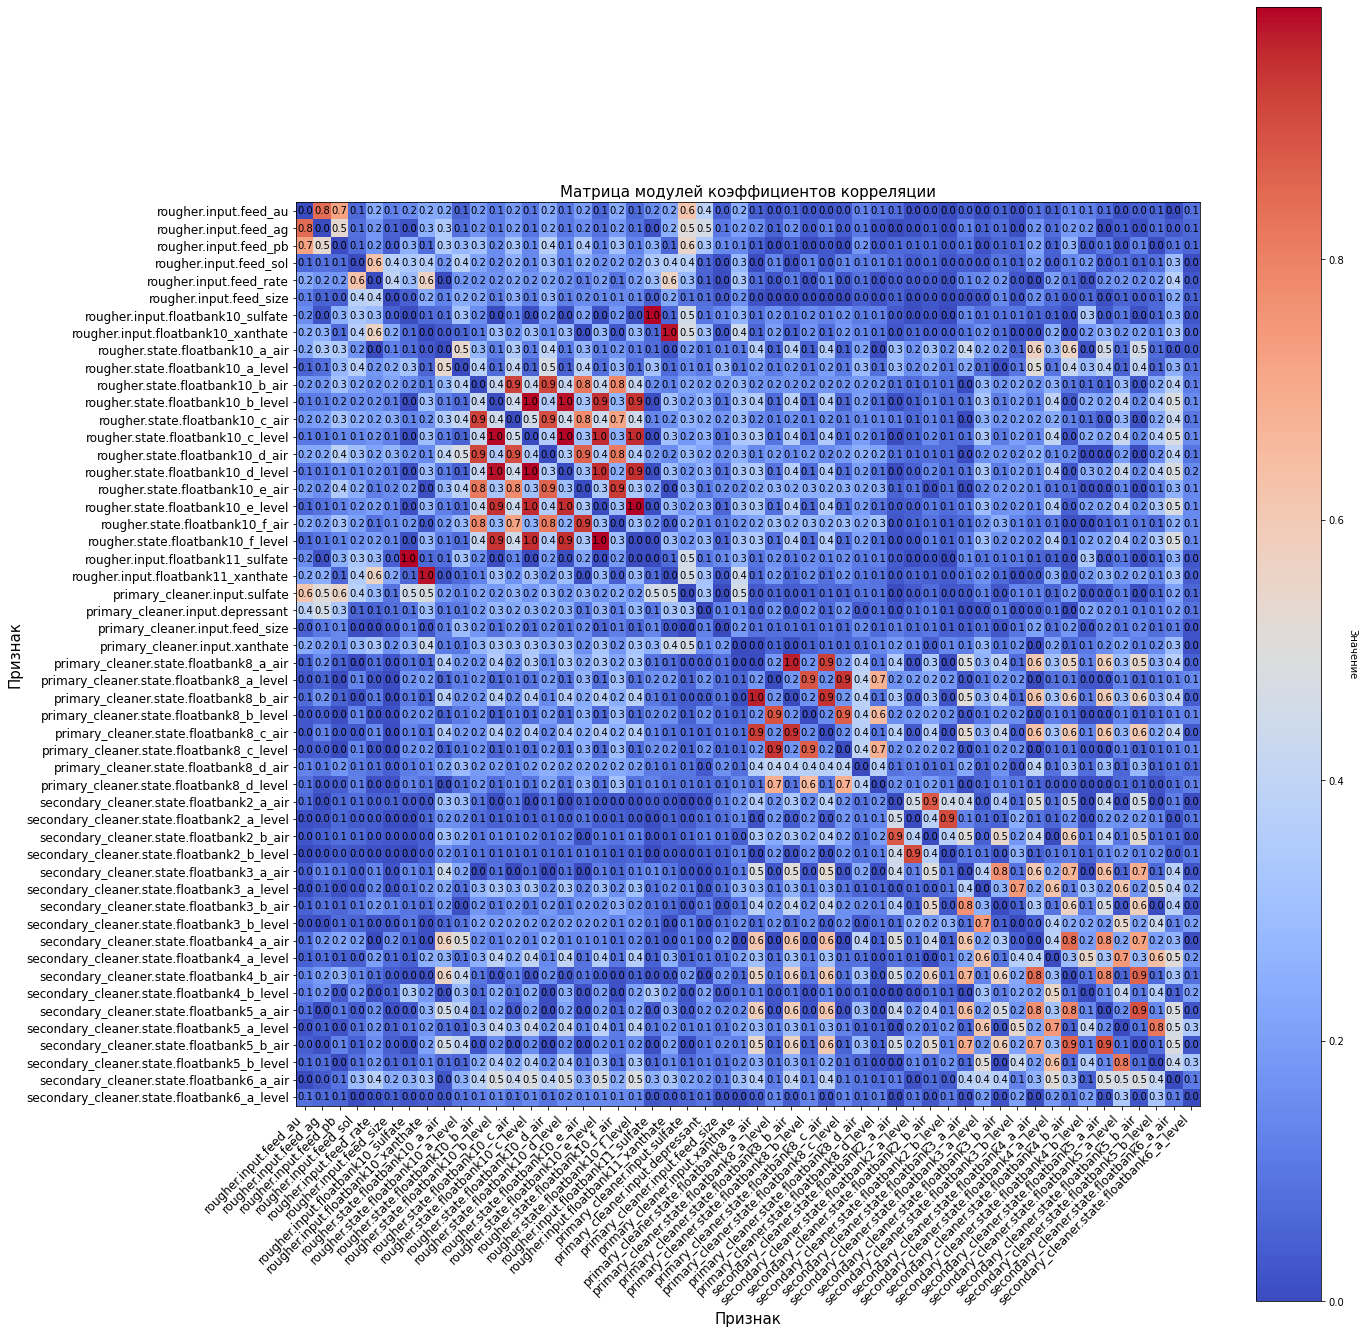

In [56]:
# Строим тепловую карту корреляции для выбранных столбцов.
print_corr_heatmap(df_train[df_test.columns].corr())

In [57]:
# Функция вывода признаков с наибольшими коэффициентами корреляции
# df_corr - dataframe с коэффициентами корреляции
# top_n - количество признаков с наибольшими коэффициентами для вывода

def print_top_corr_features(df_corr, top_n=20):
    df_corr = np.abs(df_corr).replace(1, 0)

    # Выводим признаки с наибольшими коэффициентами корреляции
    corr_values = df_corr.abs().unstack().sort_values(ascending=False)
    top_corr_features = corr_values[corr_values != 1][:top_n]

    # Создаем DataFrame с признаками и коэффициентами корреляции
    df_top_corr_features = pd.DataFrame(top_corr_features, columns=['Коэффициент_корреляции'])
    df_top_corr_features.index.names = ['Обучающая_выборка', 'Тестовая_выборка']
    df_top_corr_features.reset_index(inplace=True)

    # Выводим таблицу с признаками и коэффициентами корреляции
    print('Признаки с наибольшими коэффициентами корреляции:')
    display(df_top_corr_features)

In [58]:
# Получаем топ N признаков с наивысшей корреляцией.
print_top_corr_features(df_train[df_test.columns].corr(), 100)

Признаки с наибольшими коэффициентами корреляции:


,Обучающая_выборка,Тестовая_выборка,Коэффициент_корреляции
0,rougher.input.floatbank10_sulfate,rougher.input.floatbank11_sulfate,0.993714
1,rougher.input.floatbank11_sulfate,rougher.input.floatbank10_sulfate,0.993714
2,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_level,0.991060
3,rougher.state.floatbank10_f_level,rougher.state.floatbank10_e_level,0.991060
4,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_level,0.990409
5,rougher.state.floatbank10_d_level,rougher.state.floatbank10_c_level,0.990409
6,rougher.state.floatbank10_c_level,rougher.state.floatbank10_b_level,0.986930
7,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_level,0.986930
8,rougher.state.floatbank10_d_level,rougher.state.floatbank10_b_level,0.979168
9,rougher.state.floatbank10_b_level,rougher.state.floatbank10_d_level,0.979168


Следует отметить, что в таблице присутствуют сильно коррелирующие признаки - в основном это признаки, относящиеся к параметрам этапа, например:
- `rougher.state.floatbank10_b_level` и	`rougher.state.floatbank10_c_level`
- `primary_cleaner.state.floatbank8_b_air` и `primary_cleaner.state.floatbank8_a_air`
- `rougher.state.floatbank10_c_air` и `rougher.state.floatbank10_b_air`

Вероятнее всего это говорит о имеющейся зависимости между элементами одного и того же этапа обработки (например, объеме подаваемого воздуха). При наличии принаков с высокой корреляцией применение линейных моделей нецелесообразно без существенного преобразования обучающих признаков (удаления, усреднения и т.д. с целью исключения сильных взаимных корреляций).

###### Выводы

Исходные данные представлены в трех файлах: обучающей выборке, тестовой выборке и исходных данных (полный объем).

В обучающей и тестовой выборках присутствует большое количество признаков: 86 и 52 соответственно. Все признаки являются вещественными.

Обнаружены пропущенные значения в данных, причем доля пропусков составляет около 0.2% от общего объема в обучающей выборке и 0.1% в тестовой выборке.

Соотношение тестовой выборки к обучающей составляет примерно 1/3.

Путем оценки состава признаков обучающей и тестовой выборок удалось восстановить расширенную схему технологического процесса и определить целевые и возможные наборы обучающих признаков.

Согласно поставленной задаче, требуется прогнозировать две величины: эффективность обогащения чернового концентрата (rougher.output.recovery) и эффективность обогащения финального концентрата (final.output.recovery).

На этапе подготовки и предварительной обработки данных был выполнен расчет указанных величин для проверки. Учитывая имеющееся описание технологического процесса и результаты проверки, можно сделать следующие выводы:
- Этап флотации является независимым, поэтому модель для оценки эффективности обогащения чернового концентрата (rougher.output.recovery) можно построить только на параметрах этапа флотации.
- Финальный этап вероятно зависит от всех предыдущих, поэтому модель для оценки эффективности обогащения финального концентрата (final.output.recovery) следует строить на всех входных параметрах предыдущих этапов, включая параметры сырья и этапа флотации. Дополнительных сведений, позволяющих сделать вывод о зависимости/независимости финального этапа от исходных параметров этапа флотации, не представлено.

Также была выполнена процедура заполнения пропусков в данных, основанная на замене пропущенных значений методом использующего алгоритм k-ближайших соседей. Была оценена корреляция обучающих признаков, которую следует учитывать при подготовке моделей линейной регрессии.

## Анализ данных

###### Анализ динамики концентрации металлов

Проведем оценку изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки.

Определим перечень этапов, выходными или входными параметров которых являются концентрации веществ.

In [59]:
# Задаем словарь для этапов концентрации
stages_concentrate = {
    'rougher.input.feed': "Флотация (сырье)",
    'rougher.output.concentrate': "Флотация",
    'primary_cleaner.output.concentrate': "Первичная очистка",
    'final.output.concentrate': "Финальные характеристики"
}

# Задаем словарь для металлов
metals = {
    'au': 'Золото',
    'ag': 'Cеребро',
    'pb': 'Свинец'
}

# Задаем словарь с цветами для каждого этапа
stage_colors = {
    'Флотация (сырье)': '#FFA500',  # Оранжевый
    'Флотация': '#008080',  # Темно-циановый
    'Первичная очистка': '#800080',  # Пурпурный
    'Финальные характеристики': '#FF1493'  # Розовый
}

def get_metal_concentrate(df):
    # Создаем пустой словарь, где будем хранить концентраты металлов
    metal_concentrate = {}

    # Итерируемся по каждому металлу
    for metal in metals:
        # Формируем список столбцов концентратов для текущего металла
        concentrate_cols = [stage + '_' + metal for stage in stages_concentrate]
        
        # Извлекаем из dataframe соответствующие столбцы концентратов
        metal_concentrate[metal] = df[concentrate_cols]
        
    # Возвращаем словарь с концентратами металлов
    return metal_concentrate

def show_metal_hist(df_stacked, title, x_title):
    # Переименовываем столбцы датафрейма
    df_stacked.columns = ['date', 'stage', 'concentrate']

    # Создаем новую фигуру и ось
    fig, ax = plt.subplots(figsize=(19, 9))

    # Получаем уникальные значения этапов
    stages = df_stacked['stage'].unique()

    # Итерируемся по каждому этапу
    for stage in stages:
        # Извлекаем данные для текущего этапа
        data = df_stacked[df_stacked['stage'] == stage]['concentrate']

        # Строим гистограмму с указанными параметрами
        ax.hist(data, bins=100, alpha=0.7, color=stage_colors[stage], label=stage)

    # Устанавливаем подписи осей и заголовок
    ax.set_xlabel(x_title)
    ax.set_ylabel('Частота')
    ax.set_title(title)

    # Добавляем легенду
    ax.legend()

    # Включаем сетку
    ax.grid(True)

    # Отображаем график
    plt.show()


def show_metal_concentrate(metal_concentrate):
    # Итерируемся по каждому металлу
    for metal in metals:
        # Извлекаем dataframe с концентратами для текущего металла
        df_metal = metal_concentrate[metal]
        
        # Задаем имена столбцов на основе словаря stages_concentrate
        df_metal.columns = stages_concentrate.values()

        # Преобразуем dataframe в стековый формат
        df_stacked = df_metal.stack().reset_index()
        df_stacked.columns = ['date', 'stage', 'concentrate']

        # Отображаем гистограмму для текущего металла
        show_metal_hist(
            df_stacked,
            'Распределение по этапам концентрации металла: {0}'.format(metals[metal]),
            'Концентрация - ' + metals[metal]
        )

In [60]:
def show_stage_concentrations(df_train):
    # Определение названий стадий и соответствующих названий на русском языке
    stages = ['rougher.input.feed_', 
              'rougher.output.concentrate_', 
              'primary_cleaner.output.concentrate_', 
              'final.output.concentrate_'
             ]
    stage_names = ['Сырье перед флотацией', 
                   'Черновой концентрат', 
                   'Концентрат после первичной очистки', 
                   'Финальный концентрат'
                  ]

    # Определение металлов интереса
    metals = ['ag', 'pb', 'au']

    # Итерация по парам значений из stages и stage_names
    for stage, stage_name in zip(stages, stage_names):
        # Вычисление медианной концентрации для каждого металла в текущей стадии
        concentrations = [df_train[f'{stage}{metal}'].dropna().median() for metal in metals]

        # Вывод названия стадии на русском языке
        print(f'{stage_name}:')

        # Вывод медианной концентрации для каждого металла
        print(f'серебро: {concentrations[0]:.2f}, свинец: {concentrations[1]:.2f}, золото: {concentrations[2]:.2f}')

        # Вывод пустой строки для разделения
        print()

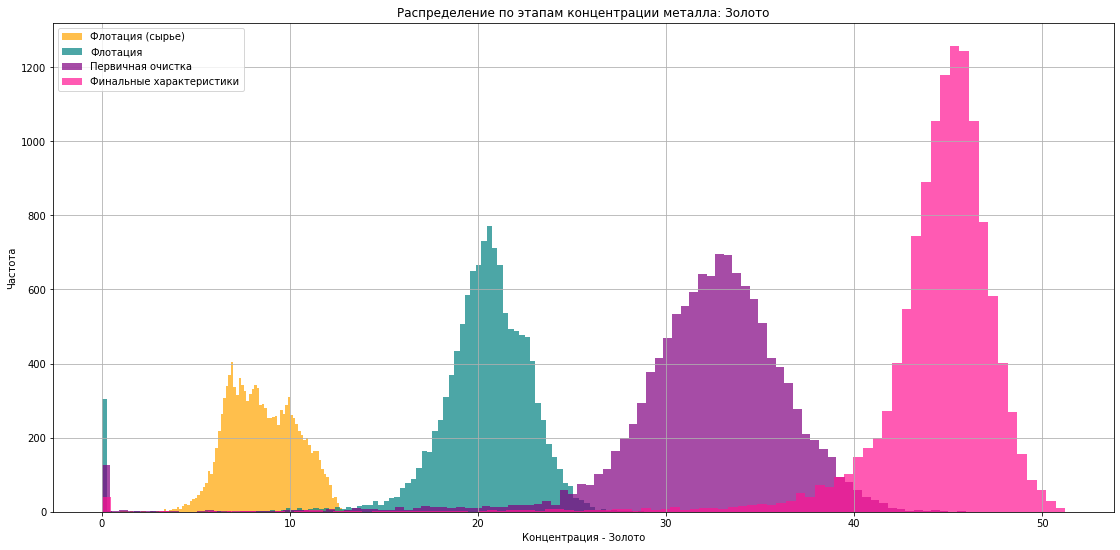

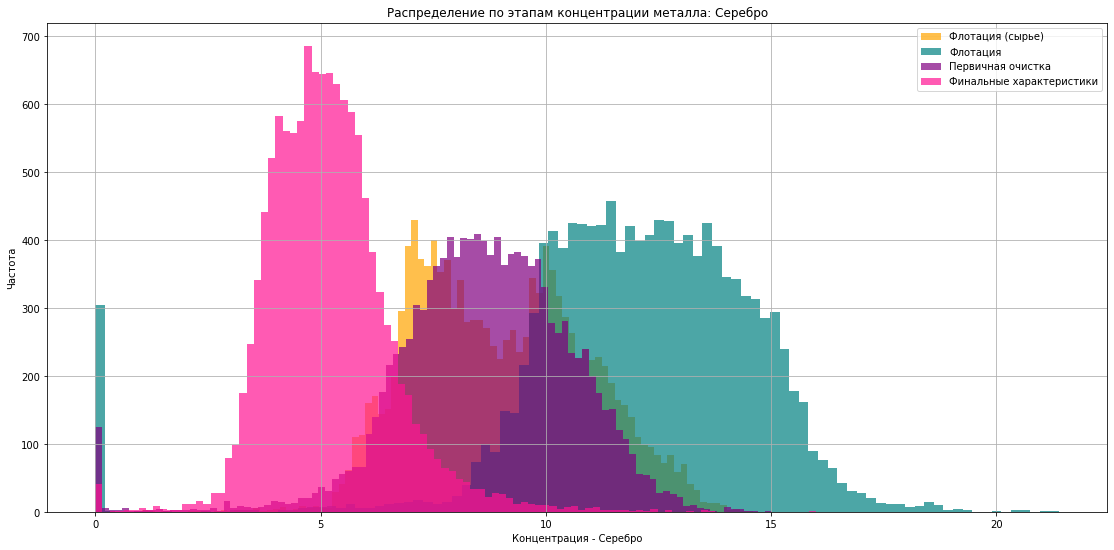

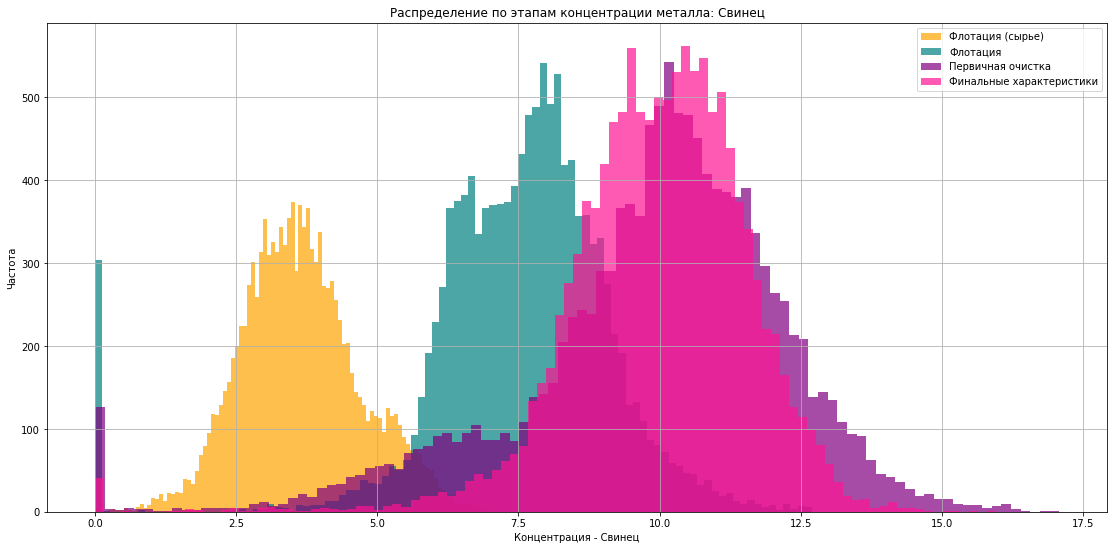

In [61]:
# Получаем таблицу с концентрацией металлов для каждого этапа
metal_concentrate = get_metal_concentrate(df_train)

# Отображаем полученные данные
show_metal_concentrate(metal_concentrate)

In [62]:
# Отображаем графики изменения концентрации металлов на различных этапах
show_stage_concentrations(df_train)

Сырье перед флотацией:
серебро: 8.88, свинец: 3.58, золото: 8.37

Черновой концентрат:
серебро: 12.20, свинец: 7.70, золото: 20.51

Концентрат после первичной очистки:
серебро: 8.70, свинец: 10.19, золото: 32.66

Финальный концентрат:
серебро: 5.08, свинец: 10.09, золото: 44.98



###### По динамике концентраций металлов по этапам обработки можно сделать следующие выводы:

- Концентрация золота последовательно увеличивается от этапа к этапу, что соответствует ожиданиям, так как основной целью технологического процесса является восстановление золота из золотосодержащей руды.
- Концентрация серебра уменьшается от этапа к этапу, указывая на значительное присутствие серебра в исходной руде в качестве сопутствующего металла.
- Концентрация свинца наименьшая на этапе флотации, а на этапах первичной и финальной очистки она практически одинакова. На финальном этапе наблюдается более компактное распределение концентрации свинца.

Однако в исходных данных присутствуют значительные выбросы, выражающиеся в нулевой концентрации. Эти аномалии следует исключить из процесса обучения, так как их доля в общем объеме данных существенна.

Для улучшения качества данных мы удалим указанные аномалии и также выбросы, выходящие за пределы межквартильного размаха распределений.

In [63]:
# Определение столбцов, для которых нужно удалить аномалии и выбросы
columns_to_clean = ['rougher.output.concentrate_au',
                    'primary_cleaner.output.concentrate_au',
                    'final.output.concentrate_au',
                    'rougher.output.concentrate_ag',
                    'primary_cleaner.output.concentrate_ag',
                    'final.output.concentrate_ag',
                    'rougher.output.concentrate_pb',
                    'primary_cleaner.output.concentrate_pb',
                    'final.output.concentrate_pb'
                   ]

# Проход по каждому столбцу
for column in columns_to_clean:
    # Вычисление межквартильного размаха (IQR) для текущего столбца
    q1 = df_train[column].quantile(0.25)
    q3 = df_train[column].quantile(0.75)
    iqr = q3 - q1
    
    # Определение границ для определения выбросов
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Удаление строк, содержащих значения, выходящие за пределы границ
    df_train = df_train[(df_train[column] >= lower_bound) & (df_train[column] <= upper_bound)]
    
df_train.shape

(10050, 88)

Еще раз оценим распределение концентрации металлов по этапам

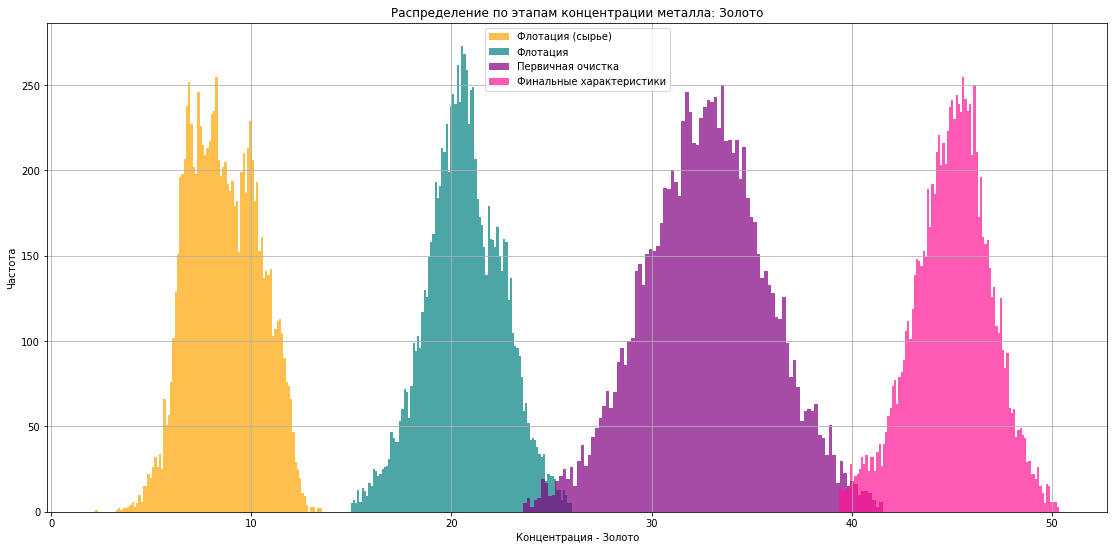

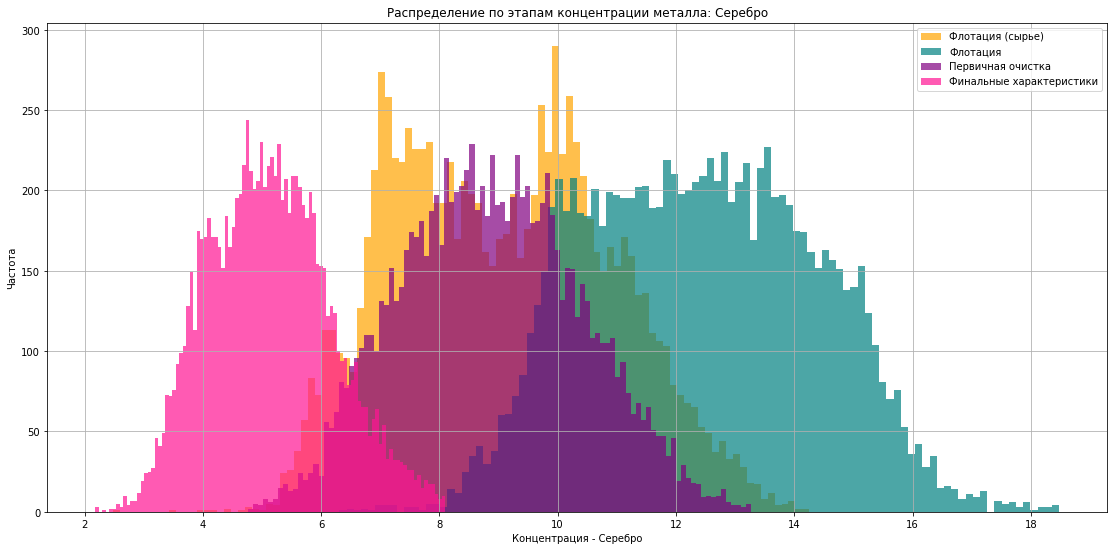

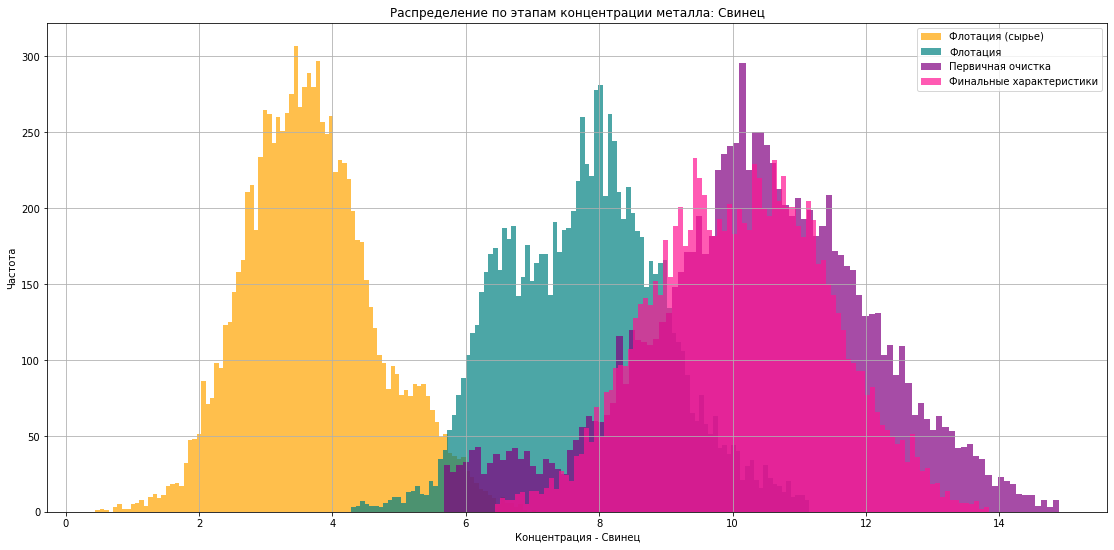

In [64]:
# Вычисляем концентрацию металлов на различных этапах производства
metal_concentrate = get_metal_concentrate(df_train)

# Отображаем графики изменения концентрации металлов на различных этапах
show_metal_concentrate(metal_concentrate)

In [65]:
# Отображаем графики изменения концентрации металлов на различных этапах производства
show_stage_concentrations(df_train)

Сырье перед флотацией:
серебро: 9.03, свинец: 3.62, золото: 8.52

Черновой концентрат:
серебро: 12.39, свинец: 7.81, золото: 20.60

Концентрат после первичной очистки:
серебро: 8.83, свинец: 10.36, золото: 32.77

Финальный концентрат:
серебро: 5.10, свинец: 10.15, золото: 45.10



###### Выводы

По результатам оценки концентрации металлов на различных этапах обработки можно сделать следующие выводы:
- Доля золота увеличивается от этапа к этапу.
- Доля сопутствующих металлов (например, серебра) уменьшается от этапа к этапу.
- Распределение концентрации всех металлов близко к нормальному.
- Были удалены аномалии в распределении концентрации металлов для последующего обучения моделей.

###### Исследование суммарной концентрации всех веществ на разных стадиях

Выполним расчет суммарных концентраций веществ на всех стадиях технологического процесса

In [66]:
for stage in stages_concentrate:
    # Формируем список столбцов металлов для текущего этапа
    metal_cols = [stage + '_' + metal for metal in metals]

    # Вычисляем сумму концентраций для каждого металла на текущем этапе
    # с помощью метода sum(axis=1), где axis=1 указывает на суммирование по столбцам
    df_train[stage + '_sum'] = df_train[metal_cols].sum(axis=1)

In [67]:
df_sum_concentrate = pd.DataFrame()

for stage in stages_concentrate:
    # Формируем список столбцов для текущего этапа, добавляя суффикс '_sum'
    stage_sum_col = stage + '_sum'
    
    # Добавляем столбец с суммарным концентратом текущего этапа к датафрейму df_sum_concentrate
    df_sum_concentrate[stage_sum_col] = df_train[stage + '_au'] + df_train[stage + '_ag'] + df_train[stage + '_pb'] + df_train[stage + '_sol']

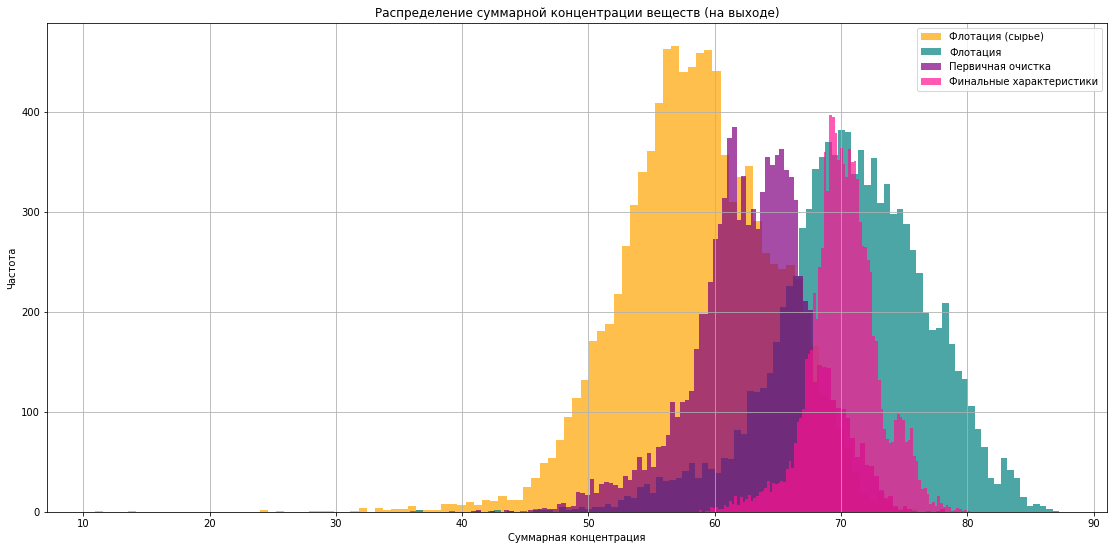

In [68]:
# Присваиваем новые имена столбцам датафрейма
df_sum_concentrate.columns = stages_concentrate.values()

# Преобразуем датафрейм в структуру "стек"
stacked_df = df_sum_concentrate.stack().reset_index()
stacked_df.columns = ['date', 'stage', 'concentrate']

# Вызываем функцию для отображения гистограммы
show_metal_hist(
    stacked_df,  # Передаем структуру "стек"
    'Распределение суммарной концентрации веществ (на выходе)',  # Указываем заголовок
    'Суммарная концентрация'  # Указываем подпись оси X
)

По результатам оценки суммарной концентрации веществ на различных этапах обработки можно сделать следующие выводы:
- Распределение суммарной концентрации веществ становится более компактным от этапа к этапу.
- В распределениях не выявлены аномалии, что может быть результатом удаления аномалий на предыдущих этапах.

###### Сравнение распределения размеров гранул сырья

Сравним распределение размеров гранул сырья на обучающей и тестовой выборках. По условиям задачи, если распределения сильно отличаются, это может повлиять на оценку модели и ее правильность.

Размеры гранул сырья являются важными параметрами на этапах флотации и первичной очистки.

In [69]:
# Создаем новый DataFrame df_feed_train, содержащий только столбцы 'rougher.input.feed_size' и 'primary_cleaner.input.feed_size'
# Исключаем строки, содержащие пропущенные значения (dropna())
df_feed_train = df_train[['rougher.input.feed_size', 'primary_cleaner.input.feed_size']].dropna()

# Создаем новый DataFrame df_feed_test, содержащий только столбцы 'rougher.input.feed_size' и 'primary_cleaner.input.feed_size'
# Исключаем строки, содержащие пропущенные значения (dropna())
df_feed_test = df_test[['rougher.input.feed_size', 'primary_cleaner.input.feed_size']].dropna()

In [70]:
def show_feed_rate(stage_name, stage_title, xlim=None):
    # Создание графиков коробки с усами
    fig, axs = plt.subplots(2, 1, figsize=(19, 6), sharex=True)

    # График коробки с усами для тренировочной выборки
    train_box = axs[0].boxplot(df_feed_train[stage_name + '.input.feed_size'], vert=False, widths=0.5, patch_artist=True, boxprops=dict(facecolor='orange'))
    axs[0].set_ylabel('Тренировочная выборка')
    axs[0].set_title('Диаграмма размаха размера гранул на этапе: ' + stage_title)
    axs[0].grid(True)

    # График коробки с усами для тестовой выборки
    test_box = axs[1].boxplot(df_feed_test[stage_name + '.input.feed_size'], vert=False, widths=0.5, patch_artist=True, boxprops=dict(facecolor='blue'))
    axs[1].set_ylabel('Тестовая выборка')
    axs[1].set_xlabel('Размер гранул')
    axs[1].grid(True)

    # Получение значений медиан для каждой выборки
    train_median = df_feed_train[stage_name + '.input.feed_size'].median()
    test_median = df_feed_test[stage_name + '.input.feed_size'].median()

    # Добавление текстового вывода медианных значений
    axs[0].text(0.95, 0.9, f'Медиана: {train_median}', transform=axs[0].transAxes, horizontalalignment='right', verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))
    axs[1].text(0.95, 0.9, f'Медиана: {test_median}', transform=axs[1].transAxes, horizontalalignment='right', verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))

    # Создание отдельного графика распределения
    fig_dist, ax_dist = plt.subplots(figsize=(19, 10))

    # График распределения для тренировочной выборки
    ax_dist.hist(df_feed_train[stage_name + '.input.feed_size'], bins=200, density=True, alpha=0.5, color='orange', label='Тренировочная выборка')
    # График распределения для тестовой выборки
    ax_dist.hist(df_feed_test[stage_name + '.input.feed_size'], bins=200, density=True, alpha=0.5, color='blue', label='Тестовая выборка')

    # Линия медианы для тренировочной выборки
    ax_dist.axvline(x=train_median, color='orange', linestyle='--', linewidth=2, label='Медиана (тренировочная выборка)')
    # Линия медианы для тестовой выборки
    ax_dist.axvline(x=test_median, color='blue', linestyle='--', linewidth=2, label='Медиана (тестовая выборка)')

    ax_dist.set_xlabel('Размер гранул')
    ax_dist.set_ylabel('Плотность')
    ax_dist.set_title('График распределения размера гранул')
    ax_dist.legend()
    ax_dist.grid(True)

    if xlim:
        ax_dist.set_xlim(0, xlim)

    plt.tight_layout()
    plt.show()


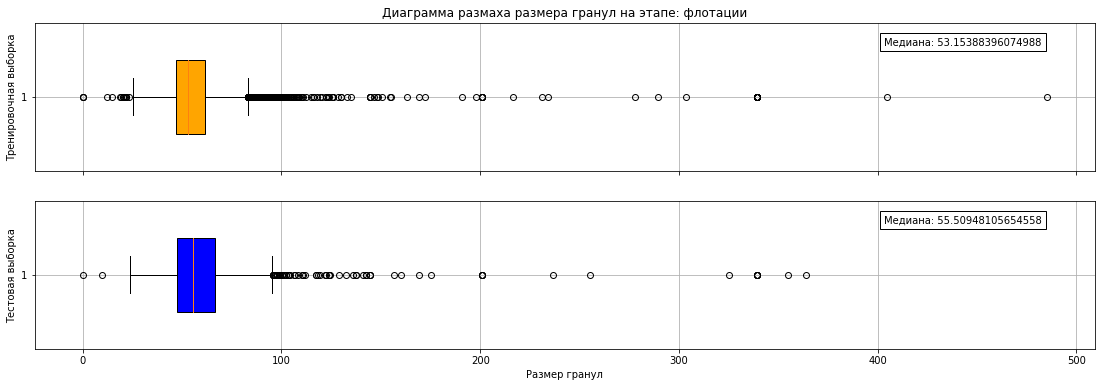

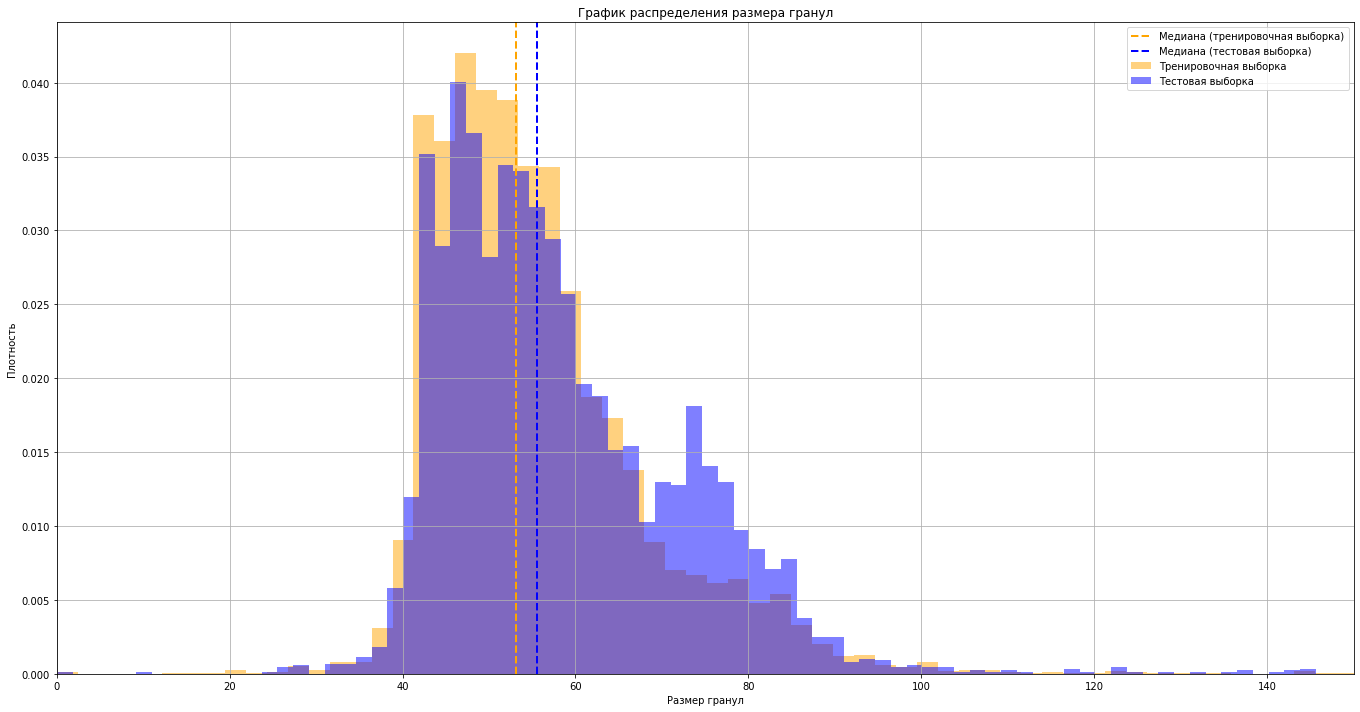

In [71]:
# Отображаем график распределения скорости подачи сырья на этапе флотации
show_feed_rate('rougher', 'флотации', 150)

Вид распределений размеров гранул сырья на этапе флотации на обучающей и тестовой выборках в целом похожи, при этом медианное значение на тестовой выборке больше (55.5 в сравнении с 54.4).

Проведем оценку распределения средних значений размеров гранул методом бутстрепа. Размер случайной выборки определим равным 5000  (сравним с размером обучающей выборки).

Отобразим полученные распределения с 99% - доверительным интервалом.

In [72]:
# Функция для создания вертикальной линии на графике
# position - позиция вертикальной линии
# color - цвет линии
def get_vertical_line(position, color):
    plt.axvline(x=position, color=color, linestyle='dashdot', linewidth=3)

# Функция для проведения бутстрэп-анализа
# feature_name - название признака, для которого проводится анализ
def make_bootstrap(feature_name):
    # Задаем генератор случайных чисел с фиксированным состоянием
    state = np.random.RandomState(random_state)

    # Получаем значения целевого признака для обучающей и тестовой выборки
    target_train = df_feed_train[feature_name]
    target_test = df_feed_test[feature_name]

    # Списки для сохранения средних значений
    means_train = []
    means_test = []

    # Проводим 10000 итераций бутстрэп-анализа
    for i in range(10000):
        # Случайным образом выбираем 5000 значений из обучающей выборки с возвращением
        means_train.append(target_train.sample(n=5000, replace=True, random_state=state).mean())
        
        # Случайным образом выбираем 5000 значений из тестовой выборки с возвращением
        means_test.append(target_test.sample(n=5000, replace=True, random_state=state).mean())

    # Преобразуем списки средних значений в Series
    means_train = pd.Series(means_train)
    means_test = pd.Series(means_test)   
    
    # Вычисляем квантили для интервальной оценки
    train_low = means_train.quantile(0.005)
    train_high = means_train.quantile(0.995)
    test_low = means_test.quantile(0.005)
    test_high = means_test.quantile(0.995)  
    
    # Создаем график
    plt.figure(figsize=(19, 9))
    
    # Строим гистограммы распределений средних значений для обучающей и тестовой выборок
    plt.hist(means_train, bins=300, density=True, color='orange', alpha=0.5, label='train')
    plt.hist(means_test, bins=300, density=True, color='blue', alpha=0.5, label='test')
    
    # Задаем подписи осей и заголовок графика
    plt.xlabel('Средний размер гранул')
    plt.ylabel('Плотность')
    plt.title('Распределение среднего размера гранул')
    
    # Добавляем легенду и сетку
    plt.legend()
    plt.grid(True)
    
    # Добавляем вертикальные линии, отображающие интервалы оценки
    get_vertical_line(train_low, 'orange')
    get_vertical_line(train_high, 'orange')
    get_vertical_line(test_low, 'blue')
    get_vertical_line(test_high, 'blue')

    # Вычисляем среднее и дисперсию для обучающей и тестовой выборок
    mean_train = means_train.mean()
    mean_test = means_test.mean()
    var_train = means_train.var()
    var_test = means_test.var()
    
    # Добавляем текстовые аннотации с информацией о среднем и дисперсии
    plt.text(0.95, 0.85, f'Среднее train: {mean_train:.2f}', ha='right', va='center', transform=plt.gca().transAxes, color='orange')
    plt.text(0.95, 0.8, f'Среднее test: {mean_test:.2f}', ha='right', va='center', transform=plt.gca().transAxes, color='blue')
    plt.text(0.95, 0.75, f'Дисперсия train: {var_train:.2f}', ha='right', va='center', transform=plt.gca().transAxes, color='orange')
    plt.text(0.95, 0.7, f'Дисперсия test: {var_test:.2f}', ha='right', va='center', transform=plt.gca().transAxes, color='blue')
    
    # Отображаем график
    plt.show()


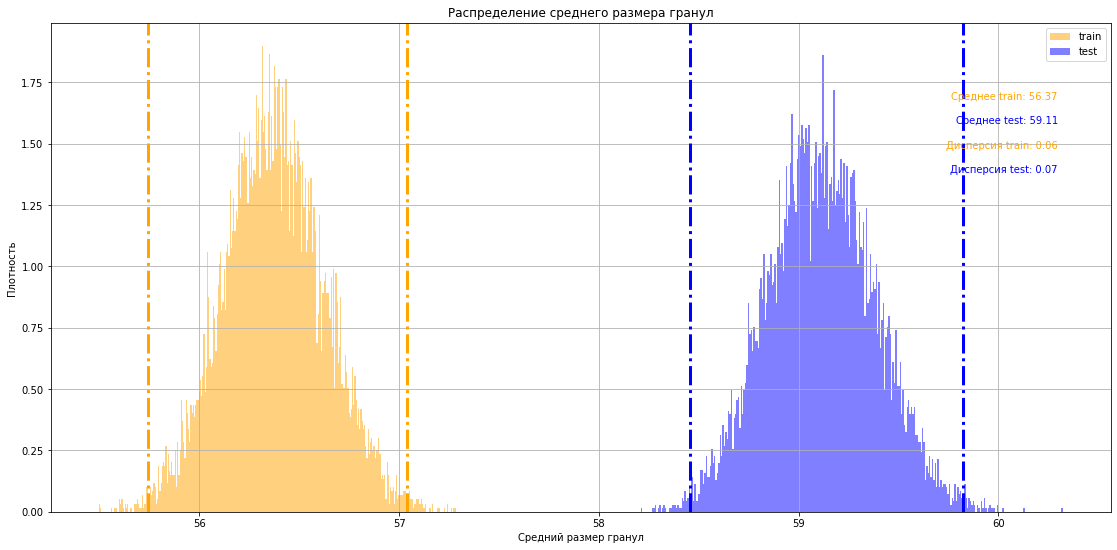

In [73]:
# Применяем bootstrap для оценки доверительного интервала для среднего размера гранул сырья на этапе флотации
make_bootstrap('rougher.input.feed_size')

Вид и форма распределений одинаковы, численные харакетристики немного отличаются (среднее, дисперсия). Целесообразно к указанным признакам применить стандартизацию, поскольку по условиям признак является значимым, а область определения на тестовой выборке не пересекается с обучающей.

Рассмотрим распределение размеров гранул сырья на этапе вторичной обработки.

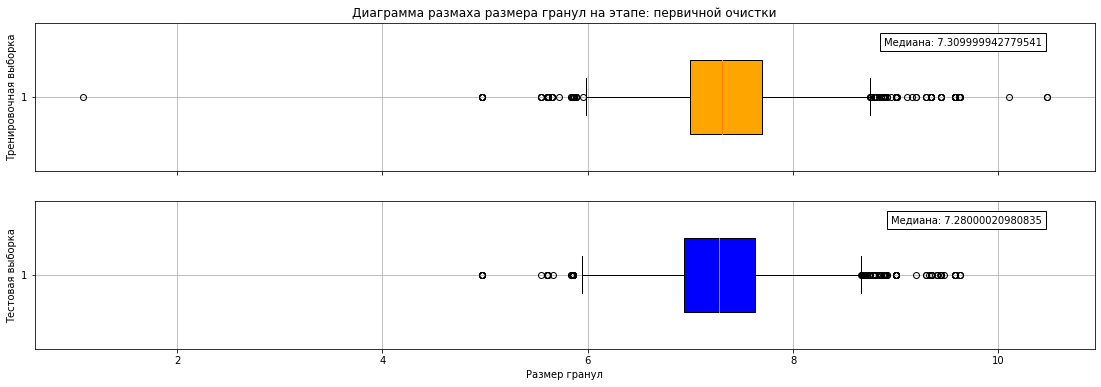

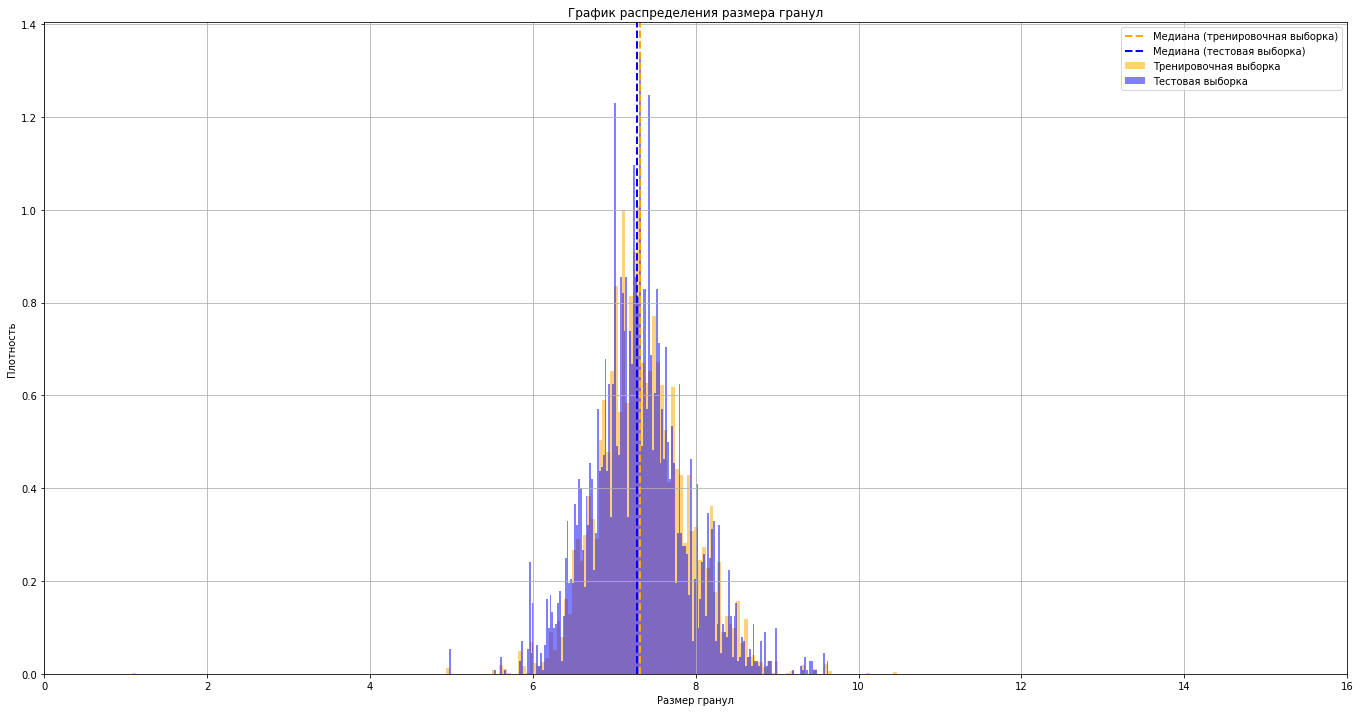

In [74]:
# Показываем распределение дебита вещества на входе в первичную очистку
show_feed_rate('primary_cleaner', 'первичной очистки', 16)

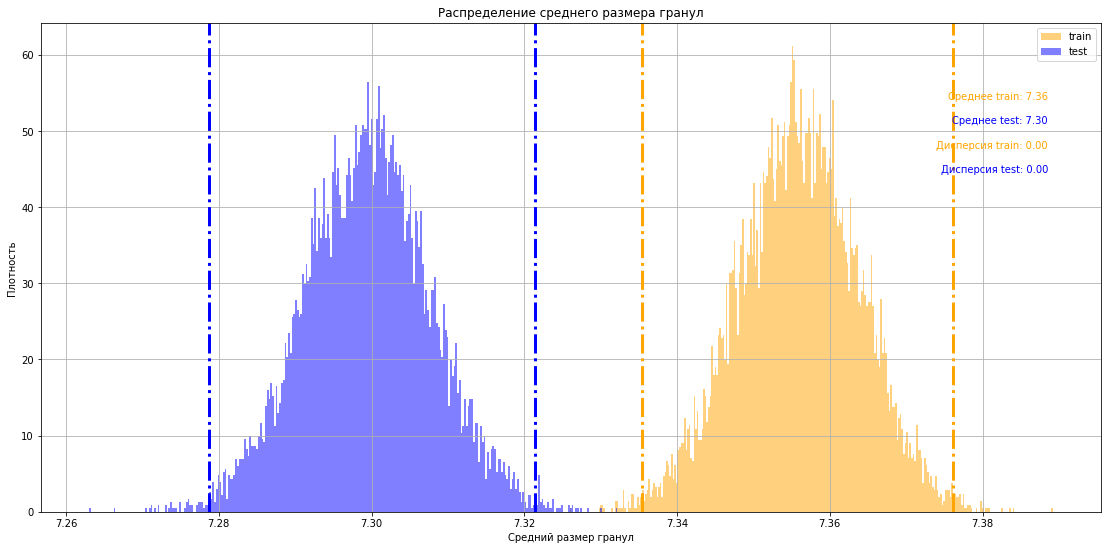

In [75]:
# Создаем бутстреп-выборки для распределения размеров гранул сырья перед первичной очисткой
make_bootstrap('primary_cleaner.input.feed_size')

Вид и форма распределений одинаковы, численные харакетристики почти не отличаются (среднее). Аналогичным образом попробуем к указанным признакам применить стандартизацию, поскольку по условиям признак является значимым, а область определения на тестовой выборке не пересекается с обучающей.

Кроме того, целесообразно исключить из обучающей выборки зоны выбросов в распределении размеров гранул сырья на этапах флотации и первичной обработки.

In [76]:
# Определение столбцов, для которых нужно удалить аномалии и выбросы
columns_to_clean = ['rougher.input.feed_size',
                    'primary_cleaner.input.feed_size',
                   ]

# Проход по каждому столбцу
for column in columns_to_clean:
    # Вычисление межквартильного размаха (IQR) для текущего столбца
    q1 = df_train[column].quantile(0.25)
    q3 = df_train[column].quantile(0.75)
    iqr = q3 - q1
    
    # Определение границ для определения выбросов
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
#     # Вывод значений границ
#     print(f'Столбец: {column}')
#     print(f'Нижняя граница: {lower_bound:.2f}')
#     print(f'Верхняя граница: {upper_bound:.2f}')
#     print()
    
    # Удаление строк, содержащих значения, выходящие за пределы границ
    df_train = df_train[(df_train[column] >= lower_bound) & (df_train[column] <= upper_bound)]

# Вывод

По результатам анализа данных следует отметить следующее:
- **Динамика концентраций металлов**:
    - Концентрация золота последовательно увеличивается на каждом этапе.
    - Концентрация серебра уменьшается от этапа к этапу, что указывает на значительную примесь серебра в исходной руде (серебро является сопутствующим металлом).
    - Концентрация свинца наименьшая на этапе флотации, а на этапах первичной и финальной очистки остается практически одинаковой. На финальном этапе распределение концентрации свинца становится более компактным.
    - Имеющиеся аномалии в распределении были удалены для последующего обучения моделей.

- **Суммарная концентрация веществ**:
    - Распределение суммарной концентрации веществ становится более компактным от этапа к этапу.

- **Размеры гранул**:
    - Вид и форма распределений размеров гранул одинаковы, но численные характеристики, такие как среднее и дисперсия, различаются. Рекомендуется применить стандартизацию к размерам гранул сырья, поскольку этот признак является значимым, а диапазон значений в тестовой выборке не пересекается с обучающей выборкой.
    - Имеющиеся аномалии в распределении были удалены для последующего обучения моделей.

Выше представлены основные выводы на основе проведенного анализа данных.

## Модель

Мера оценки (`scoring`) для использования при кросс-валидации модели.

In [77]:
# мера, используемая при кросс-валидации - sMAPE
scoring = make_scorer(smape, greater_is_better=False)

Определим функцию `print_scores`, которая используется для вывода результатов подбора гиперпараметров с помощью `GridSearchCV`.

In [78]:
def print_scores(grid_search, params):
    # Выводим наилучшие параметры модели
    print('Наилучшие параметры:')
    
    # Получаем словарь с лучшими параметрами
    best_parameters = grid_search.best_params_

    # Перебираем ключи и значения лучших параметров и выводим их
    for param_name, param_value in best_parameters.items():
        print('\t%s: %r' % (param_name, param_value))
    
    # Выводим наилучшее значение метрики SMAPE
    print('Наилучшее значение метрики SMAPE: %0.3f' % np.abs(grid_search.best_score_))

Определим функцию `print_scores_on_test`, которая используется для вывода результатов моделирования на тестовых данных.

In [79]:
def print_scores_on_test(grid_search, params, X_test, Y_test):
    # Выводим параметры модели
    print('Параметры модели:')
    best_parameters = grid_search.best_params_
    
    for param_name, param_value in best_parameters.items():
        print('\t%s: %r' % (param_name, param_value))
    
    # Вычисляем и выводим значение метрики sMAPE на тестовых данных
    smape_score = smape(Y_test, grid_search.predict(X_test))
    print('Значение метрики sMAPE на тестовых данных:', np.abs(smape_score))

In [80]:
# Шаг 1: Импутация с использованием imputer_knn
step1 = ('imp', imputer_knn)

# Шаг 2: Импутация с использованием SimpleImputer
# Замена пропущенных значений на среднее с использованием SimpleImputer
step2 = ('imp2', SimpleImputer(missing_values=np.nan, strategy='mean', copy=False))

# Шаг 3: Стандартизация с использованием StandardScaler
# Стандартизация признаков с помощью StandardScaler
step3 = ('std', StandardScaler(copy=False, with_mean=True, with_std=True))

# Список transform_steps
transform_steps = [step1, step2, step3]

# Модель этапа флотации

Определим обучающие и целевые признаки.

Для модели этапа флотации обучающими являются только признаки этапа флотации (с префиксом `rougher` - параметры сырья и параметры этапа), целевым - `rougher.output.recovery`

In [81]:
# Определение списка целевой переменной для этапа rougher
target_rougher = ['rougher.output.recovery']

# Определение списка признаков для этапа rougher
features_rougher = [col for col in df_test.columns if 'rougher' in col and 'output' not in col]

# Определение списка признаков для модели линейной регрессии на этапе rougher
features_rougher_lr = [
    'rougher.input.feed_au', 'rougher.input.feed_size', 'rougher.input.feed_sol',
    'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate',
    'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level'
]

# Линейная регрессия

In [82]:
# Выделение признаков для обучающей выборки на этапе rougher
X_train = df_train[features_rougher_lr]
# Выделение целевой переменной для обучающей выборки на этапе rougher
Y_train = df_train[target_rougher]

Проверим, что мультиколлинеарных признаков нет.

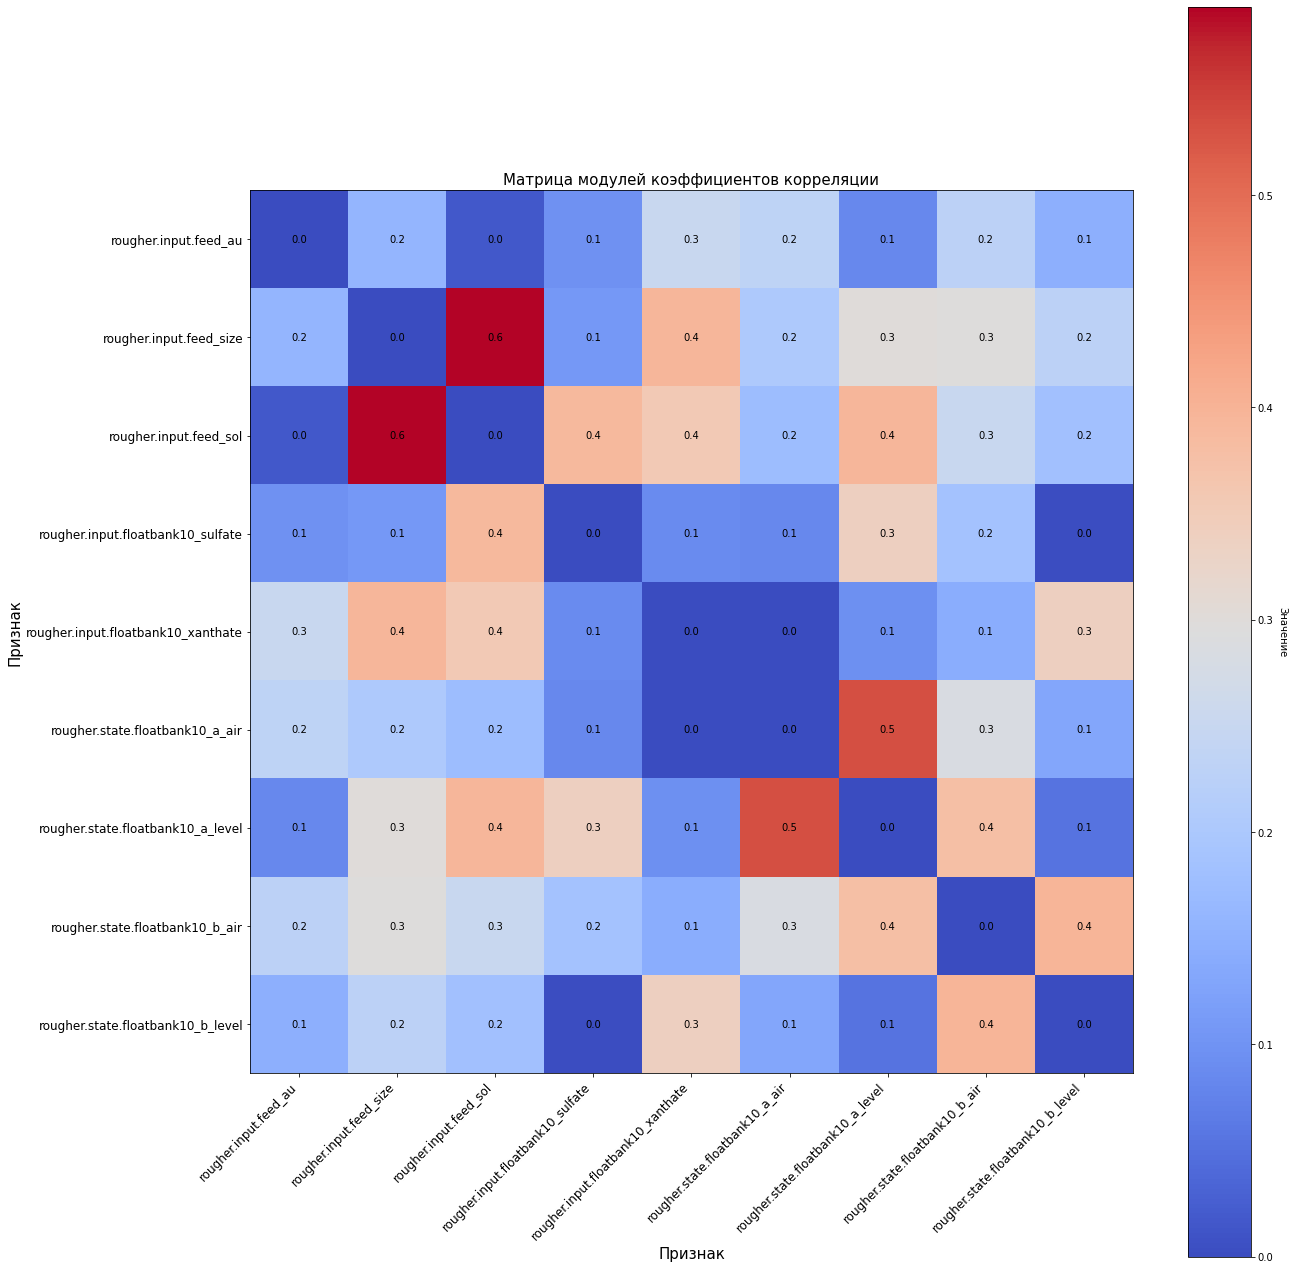

In [83]:
# Печатаем тепловую карту корреляции признаков в тренировочной выборке
print_corr_heatmap(X_train.corr(), (19,19))

In [84]:
# Печатаем топ коррелирующих признаков в тренировочной выборке
print_top_corr_features(X_train.corr())

Признаки с наибольшими коэффициентами корреляции:


,Обучающая_выборка,Тестовая_выборка,Коэффициент_корреляции
0,rougher.input.feed_sol,rougher.input.feed_size,0.588702
1,rougher.input.feed_size,rougher.input.feed_sol,0.588702
2,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,0.532039
3,rougher.state.floatbank10_a_level,rougher.state.floatbank10_a_air,0.532039
4,rougher.state.floatbank10_b_level,rougher.state.floatbank10_b_air,0.395705
5,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,0.395705
6,rougher.input.feed_size,rougher.input.floatbank10_xanthate,0.395466
7,rougher.input.floatbank10_xanthate,rougher.input.feed_size,0.395466
8,rougher.state.floatbank10_a_level,rougher.input.feed_sol,0.395259
9,rougher.input.feed_sol,rougher.state.floatbank10_a_level,0.395259


In [85]:
# Создание объекта модели линейной регрессии
model_lr = LinearRegression()

# Задание параметров для поиска по сетке
params_lr = {
    'model__fit_intercept': [True, False],# Определяет, следует ли включать интерсепт (свободный член) в модель
    'model__normalize': [True, False],    # Определяет, следует ли нормализовать входные данные перед обучением модели
    'model__copy_X': [True, False],       # Определяет, следует ли создавать копию входных данных перед обучением модели
#     'model__positive': [True, False],     # Определяет, следует ли ограничивать предсказания модели положительными значениями
}

In [86]:
# Создание конвейера с преобразованиями и моделью
pipeline = Pipeline(transform_steps + [('model', model_lr)])

# Создание объекта GridSearchCV для поиска по сетке
grid_search_lr = GridSearchCV(
    estimator=pipeline,  # Используем конвейер как оцениватель
    param_grid=params_lr,  # Задаем сетку параметров для перебора
    cv=15,  # Количество кросс-валидационных разбиений
    scoring=scoring,  # Метрика оценки качества модели
)

In [87]:
%%time
# Засекаем время выполнения обучения модели

# Обучение модели с помощью grid_search.fit
grid_search_lr.fit(X_train, Y_train.values.ravel())

# Вывод результатов с помощью print_scores
print_scores(grid_search_lr, params_lr)

Наилучшие параметры:
	model__copy_X: True
	model__fit_intercept: True
	model__normalize: True
Наилучшее значение метрики SMAPE: 4.572
CPU times: user 2.11 s, sys: 725 ms, total: 2.84 s
Wall time: 2.78 s


**Наилучшим значением метрики sMAPE линейной регрессии на этапе обучения является значение 4.57**

# Градиентный бустинг для задачи регрессии (LGBMRegressor)

In [88]:
# Создание объекта модели LGBMRegressor
model_LGBMR = LGBMRegressor(
    random_state=random_state,
#     device = 'gpu'
)

# Задание параметров для поиска по сетке
params_LGBMR = {
    'model__boosting_type': ['gbdt', 'dart'],  # Тип градиентного бустинга
    'model__num_leaves': [20, 30, 40, 50, 60],  # Количество листьев в деревьях
    'model__learning_rate': [0.1, 0.05, 0.01],  # Скорость обучения
    'model__n_estimators': [100, 200, 300, 400, 500],  # Количество деревьев
    'model__max_depth': [-1, 10, 50],
}

In [89]:
# Создание конвейера с преобразованиями и моделью
pipeline = Pipeline(transform_steps + [('model', model_LGBMR)])

# Создание объекта GridSearchCV для поиска по сетке
grid_search_LGBMR = GridSearchCV(
    estimator=pipeline,  # Используем конвейер как оцениватель
    param_grid=params_LGBMR,  # Задаем сетку параметров для перебора
    cv=10,  # Количество кросс-валидационных разбиений
    scoring=scoring  # Метрика оценки качества модели
)

In [ ]:
%%time
# Засекаем время выполнения обучения модели

# Обучение модели с помощью grid_search.fit
grid_search_LGBMR.fit(X_train, Y_train.values.ravel())

# Вывод результатов с помощью print_scores
print_scores(grid_search_LGBMR, params_LGBMR)

In [77]:
# Данные результаты получены при расчёте на ноутбуке, так как по 
# неизвестным причинам Jupyterhub не в состоянии произвести данный расчёт

# Наилучшие параметры:
# 	model__boosting_type: 'gbdt'
# 	model__learning_rate: 0.01
# 	model__max_depth: 10
# 	model__n_estimators: 200
# 	model__num_leaves: 50
# Наилучшее значение метрики SMAPE: 4.622
# Wall time: 23min 39s

**Наилучшим значением метрики sMAPE модели градиентного бустинга на этапе обучения является значение 4.62**

# Случайный лес

In [78]:
# Назначаем переменные X_train и Y_train для тренировочных данных
X_train = df_train[features_rougher]
Y_train = df_train[target_rougher]

In [80]:
# Создаем объект модели RandomForestRegressor с заданным random_state
model_rfr = RandomForestRegressor(
    n_jobs=-1, 
    random_state=random_state
)

# Задаем параметры для поиска по сетке
params_rfr = {
    'model__n_estimators': [5, 10, 20, 30, 40, 50],  # Количество деревьев в случайном лесу. Проверяются четыре значения.
    'model__max_depth': [5, 7, 10, 12, 15, 17],  # Максимальная глубина каждого дерева в случайном лесу. Проверяются три значения.
    'model__min_samples_split': [2, 3],  # Минимальное количество образцов, необходимых для разделения узла. Проверяются два значения.
    'model__min_samples_leaf': [1, 2, 3],  # Минимальное количество образцов, необходимых для формирования листа. Проверяются три значения.
    'model__max_features': ['auto', 'sqrt']  # Количество признаков, рассматриваемых при каждом делении. Проверяются два значения.
}

In [81]:
# Создаем пайплайн с преобразованиями и моделью
pipeline = Pipeline(steps=transform_steps + [('model', model_rfr)])

# Создаем объект GridSearchCV для выполнения поиска по сетке
grid_search_rfr = GridSearchCV(
    estimator=pipeline,  # Задаем пайплайн как оцениваемую модель
    param_grid=params_rfr,  # Задаем сетку параметров для поиска
    cv=15,  # Задаем количество фолдов в кросс-валидации
    scoring=scoring,  # Задаем метрику оценки
)

In [82]:
%%time
# Обучаем модель GridSearchCV на тренировочных данных
grid_search_rfr.fit(X_train, Y_train.values.ravel())

# Выводим оценки результатов наилучшей модели и ее параметры
print_scores(grid_search_rfr, params_rfr)

In [84]:
# Данные результаты получены при расчёте на ноутбуке, так как по 
# неизвестным причинам Jupyterhub не в состоянии произвести данный расчёт

# Наилучшие параметры:
# 	model__max_depth: 10
# 	model__max_features: 'sqrt'
# 	model__min_samples_leaf: 3
# 	model__min_samples_split: 3
# 	model__n_estimators: 30
# Наилучшее значение метрики SMAPE: 4.280
# Wall time: 18min 44s

**Наилучшим значением метрики sMAPE модели случайного леса на этапе обучения является значение 4.28**

# Решающее дерево

In [85]:
# Создаем объект модели DecisionTreeRegressor с заданным random_state
model_dtr = DecisionTreeRegressor( 
    random_state=random_state
)

params_dtr = {
    'model__max_depth': [5, 7, 10, 15, 20, 25],  # Максимальная глубина дерева
    'model__min_samples_split': [2, 3, 4, 5, 6], # Минимальное количество образцов, необходимых для разделения узла
    'model__min_samples_leaf': [1, 2, 3, 4, 5],  # Минимальное количество образцов, необходимых для листового узла
    'model__max_features': ['auto', 'sqrt', 'log2']
}

In [86]:
# Создаем объект GridSearchCV для выполнения поиска по сетке
grid_search_dtr = GridSearchCV(
    estimator=Pipeline(transform_steps + [('model', model_dtr)]),  # Задаем пайплайн с преобразованиями и моделью
    param_grid=params_dtr,  # Задаем сетку параметров для поиска
    cv=35,  # Задаем количество фолдов в кросс-валидации
    scoring=scoring,  # Задаем метрику оценки
)

In [87]:
%%time
# Запускаем таймер для измерения времени выполнения

# Обучаем модель GridSearchCV на тренировочных данных
grid_search_dtr.fit(X_train, Y_train.values.ravel())

# Выводим оценки результатов наилучшей модели и ее параметры
print_scores(grid_search_dtr, params_dtr)

In [88]:
# Данные результаты получены при расчёте на ноутбуке, так как по 
# неизвестным причинам Jupyterhub не в состоянии произвести данный расчёт

# Наилучшие параметры:
# 	model__max_depth: 5
# 	model__max_features: 'auto'
# 	model__min_samples_leaf: 2
# 	model__min_samples_split: 2
# Наилучшее значение метрики SMAPE: 4.355
# Wall time: 17min 42s

**Наилучшим значением метрики sMAPE модели решающего дерева на этапе обучения является значение 4.51**

# CatBoost

Воспользуемся библиотекой CatBoost, реализующую схему градиентного бустинга. 

Поскольку метрика sMAPE не поддерживается на уровне ядра библиотеки, реализуем ее в виде пользовательской метрики (по аналогии с реализацией метрики RMSE в описании CatBoost)

Формула для расчета RMSE [(catboost.ai)](https://catboost.ai/docs/concepts/loss-functions-regression.html):

$$RMSE = \sqrt{ \cfrac{ \sum \limits _{i=1}^{N} (y_{i} - \hat y_{i})^2 * w_{i}} { \sum \limits _{i=1}^{N}  w_{i} }   }  $$


где:
- $y_{i}$ - значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество
- $\hat y_{i}$ - значение предсказания для объекта с порядковым номером i, например, в тестовой выборке
- $w_{i}$ - весовая харакетристика с порядковым номером i в выборке
- $N$ - количество объектов в выборке
- $\sum \limits _{i=1}^{N}$ - cуммирование по всем объектам выборки (i от 1 до N)

In [89]:
class RmseMetric(object):
    def get_final_error(self, error, weight):
        # Вычисляем и возвращаем среднеквадратичное отклонение (RMSE)
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        # Указываем, что меньшее значение метрики является оптимальным
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        # Вычисляем сумму ошибок и сумму весов
        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((approx[i] - target[i])**2)

        return error_sum, weight_sum

В этом коде выполняются следующие шаги:

1. Создается класс RmseMetric.
2. В методе `get_final_error(self, error, weight)` вычисляется и возвращается среднеквадратичное отклонение (`RMSE`) путем деления суммарной ошибки (`error`) на суммарный вес (`weight`).
3. В методе `is_max_optimal(self)` указывается, что меньшее значение метрики является оптимальным.
4. В методе `evaluate(self, approxes, target, weight)` вычисляется ошибка и вес.
  - `approxes` - список с одним элементом, содержащий предсказанные значения.
  - `target` - целевые значения.
  - `weight` - веса (если они заданы).
5. В цикле проходится по элементам предсказанных значений и целевых значений, вычисляются веса и суммируются ошибки и веса.
6. Возвращается сумма ошибок и сумма весов.

Формула для расчета sMAPE [(catboost.ai)](https://catboost.ai/docs/concepts/loss-functions-regression.html):

$$sMAPE = \cfrac{ 100 * \sum \limits _{i=1}^{N} \cfrac{|y_{i} - \hat y_{i}| * w_{i}}{(|y_{i}| + |\hat y_{i}|) / 2} } { \sum \limits _{i=1}^{N}  w_{i} }    $$


где:
- $y_{i}$ - значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество
- $\hat y_{i}$ - значение предсказания для объекта с порядковым номером i, например, в тестовой выборке
- $w_{i}$ - весовая харакетристика с порядковым номером i в выборке
- $N$ - количество объектов в выборке
- $\sum \limits _{i=1}^{N}$ - cуммирование по всем объектам выборки (i от 1 до N)

In [90]:
class SMAPEMetric(object):
    def get_final_error(self, error, weight):
        # Вычисляем и возвращаем симметричную абсолютную процентную ошибку (SMAPE)
        return 100 * error / (weight + 1e-38)

    def is_max_optimal(self):
        # Указываем, что меньшее значение метрики является оптимальным
        return False

    def evaluate(self, approxes, target, weight):
        # Проверяем размеры входных данных
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        # Получаем прогнозы и целевую переменную
        approx = approxes[0]

        # Инициализируем переменные для суммирования ошибки и весов
        error_sum = 0.0
        weight_sum = 0.0
        for i in range(len(approx)):
            # Вычисляем вес
            w = 1.0 if weight is None else weight[i]
            weight_sum += w

            # Вычисляем симметричную абсолютную процентную ошибку (SMAPE) для каждого примера
            error_sum += w * (2 * np.abs(approx[i] - target[i]) / (np.abs(approx[i]) + np.abs(target[i])))

        return error_sum, weight_sum


В этом коде выполняются следующие шаги:

1. Создается класс `SMAPEMetric`.
2. В методе `get_final_error(self, error, weight)` вычисляется и возвращается симметричная абсолютная процентная ошибка (`SMAPE`) путем деления суммарной ошибки (`error`) на суммарный вес (`weight`) и умножения на 100.
3. В методе `is_max_optimal(self)` указывается, что меньшее значение метрики является оптимальным.
4. В методе `evaluate(self, approxes, target, weight)` вычисляется ошибка и вес.
  - `approxes` - список с одним элементом, содержащий предсказанные значения.
  - `target` - целевые значения.
  - `weight` - веса (если они заданы).
5. В цикле проходится по элементам предсказанных значений и целевых значений, вычисляются веса и суммируются ошибки и веса.
6. Возвращается сумма ошибок и сумма весов.

Определим параметры модели CatBoostRegressor

`CatBoostRegressor` - это модель градиентного бустинга, основанная на алгоритме `CatBoost`, который является одним из популярных алгоритмов градиентного бустинга. `CatBoost` является открытым исходным кодом и разработан компанией `Yandex`.

In [91]:
# Создаем объект модели CatBoostRegressor с заданными параметрами
model_cbr = CatBoostRegressor(
    verbose=10000,  # Вывод информации о процессе обучения на каждой сотой итерации
    eval_metric=SMAPEMetric(),  # Используем пользовательскую метрику SMAPEMetric
    task_type="CPU",  # Задаем тип задачи (CPU)
    iterations=10000  # Количество итераций обучения
)

In [92]:
# Обучаем модель на тренировочных данных
model_cbr.fit(
    df_train[features_rougher],  # Признаки для обучения модели (входные данные для фазы rougher)
    df_train[target_rougher],  # Целевая переменная для обучения модели (выходные данные для фазы rougher)
);

Learning rate set to 0.008985
0:	learn: 5.6959068	total: 777ms	remaining: 2h 9m 32s
9999:	learn: 1.2647181	total: 1m 3s	remaining: 0us


In [93]:
%%time
# Запускаем таймер для измерения времени выполнения

# Вычисляем значение метрики sMAPE на кросс-валидации
smape_scores = cross_val_score(
    model_cbr,  # Используем модель model
    df_train[features_rougher],  # Признаки для обучения модели (входные данные для фазы rougher)
    df_train[target_rougher].values.ravel(),  # Целевая переменная для обучения модели (выходные данные для фазы rougher)
    cv=30,  # Количество фолдов в кросс-валидации
    scoring=scoring  # Метрика оценки (sMAPE)
)

# Вычисляем среднее значение метрики sMAPE
smape_mean = smape_scores.mean()

# Выводим значение метрики sMAPE на кросс-валидации
print('Значение метрики sMAPE на кросс-валидации:', smape_mean)

Learning rate set to 0.008937
0:	learn: 5.6472793	total: 281ms	remaining: 46m 46s
9999:	learn: 1.2193249	total: 1m 3s	remaining: 0us
Learning rate set to 0.008937
0:	learn: 5.6914250	total: 226ms	remaining: 37m 35s
9999:	learn: 1.2158446	total: 1m 5s	remaining: 0us
Learning rate set to 0.008937
0:	learn: 5.5738756	total: 249ms	remaining: 41m 31s
9999:	learn: 1.2133184	total: 1m 4s	remaining: 0us
Learning rate set to 0.008937
0:	learn: 5.4474539	total: 304ms	remaining: 50m 38s
9999:	learn: 1.2150771	total: 1m 2s	remaining: 0us
Learning rate set to 0.008937
0:	learn: 5.4401656	total: 273ms	remaining: 45m 33s
9999:	learn: 1.2104480	total: 59.7s	remaining: 0us
Learning rate set to 0.008937
0:	learn: 5.5960864	total: 286ms	remaining: 47m 40s
9999:	learn: 1.2184820	total: 1m	remaining: 0us
Learning rate set to 0.008937
0:	learn: 5.5974318	total: 222ms	remaining: 37m 1s
9999:	learn: 1.2098884	total: 1m 3s	remaining: 0us
Learning rate set to 0.008937
0:	learn: 5.6684504	total: 226ms	remaining:

**Наилучшим значением метрики sMAPE градиентного бустинга на этапе обучения является значение -3.98**

На этапе обучения самые лучшие показатели метрики sMAPE у градиентного бустинга (CatBoost) - 3.98. Однако все иные модели также демонстрируют близкие показатели:
1. Градиентный бустинг (CatBoost) - -3.98;
2. Случайный лес - 4.28;
3. Решающее дерево - 4.51;
4. Линейная регрессия - 4.57;
5. Градиентный бустинг для задачи регрессии (LGBMRegressor) - 4.62.

Сделаем предсказания на тестовых признаках и вычислим метрику sMAPE rougher.output.recovery используя модель случайного леса

###### Подготовка тестового датасета

С учетом полученных ранее результатов обучение моделей для оценки параметров эффективности обогащения чернового и финального концентрата (`rougher.output.recovery` и `final.output.recovery` соответственно) будем проводить независимо.

В качестве эталоных значений целевых признаков возьмем значения из исходного (полного) набора данных по соответствующим индексам.

In [94]:
# Объединение столбцов 'rougher.output.recovery' и 'final.output.recovery' из df_full с df_test
df_test = pd.concat([df_test, df_full[['rougher.output.recovery', 'final.output.recovery']].loc[df_test.index]], axis=1)

# Оставим только записи с заполненным значением целевых признаков.

# Отбор строк в df_test, где значения столбцов 'rougher.output.recovery' и 'final.output.recovery' не равны NaN
df_test = df_test[df_test['rougher.output.recovery'].notnull() & df_test['final.output.recovery'].notnull()]

In [95]:
# Выбираем признаки для тестовой выборки для этапа флотации
X_test = df_test[features_rougher]

# Выбираем целевой признак для тестовой выборки для этапа флотации
Y_test = df_test[target_rougher]

In [97]:
# Получаем предсказанные значения целевой переменной на тестовых данных
Y_predicted = model_cbr.predict(X_test)

# Вычисляем значение метрики sMAPE на тестовых данных
smape_score = smape(Y_test.values.ravel(), Y_predicted)

# Выводим значение метрики sMAPE на тестовых данных
print('Значение метрики sMAPE на тестовых данных:', smape_score)

Значение метрики sMAPE на тестовых данных: 3.069891982549255


###### Проверка на адекватность

Для проверки моделей на адекватность в качестве базовой (dummy-модели) возьмем модель, заполняющая целевой признак медианой целевого признака обучающей выборки.

In [98]:
# Создаем экземпляр DummyClassifier с постоянной стратегией
# Константное значение устанавливается в медиану Y_train
dummy_classifier = DummyClassifier(constant=Y_train.median(), random_state=random_state)

# Обучаем DummyClassifier на обучающих данных
dummy_classifier.fit(X_train, Y_train)

# Вычисляем метрику sMAPE на тестовых данных
# Фактические значения передаются как Y_test.values.ravel()
# Предсказанные значения получаются с помощью dummy_classifier.predict(X_test)
smape_score = smape(Y_test.values.ravel(), dummy_classifier.predict(X_test))

# Выводим значение метрики sMAPE
print('Значение dummy метрики sMAPE на тестовых данных:', smape_score)

Значение dummy метрики sMAPE на тестовых данных: 6.434319771717827


Полученное значение хуже значений метрики sMAPE рассмотренных выше моделей.

###### Выводы

Значение метрики sMAPE (3.07) на тестовых данных получено с помощью градиентного бустинга (CatBoost) и оно гораздо лучше значения метрики dummy-модели (6.43)

In [99]:
# Указываем значение sMAPE для этапа флотации
sMAPE_rougher = 3.07

# Модель финальных характеристик

Определим обучающие и целевые признаки.

Для модели предсказания финальных характеристик процесса золотообработки обучающими являются все признаки параметров сырья и параметров этапа, целевым - `final.output.recovery`

In [100]:
# Определяем целевую переменную
target_final = ['final.output.recovery']

# Определяем список признаков, исключая столбцы, содержащие 'output' в названии
features_final = [col for col in df_test.columns if 'output' not in col]

# Определяем список признаков для модели линейной регрессии
features_final_lr = [
    'rougher.input.feed_au', 'rougher.input.feed_size', 'rougher.input.feed_sol',
    'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate',
    'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
    'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
    'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
    'primary_cleaner.input.sulfate', 'primary_cleaner.input.xanthate',
    'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level',
    'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level',
    'secondary_cleaner.state.floatbank2_a_air', 'secondary_cleaner.state.floatbank2_a_level',
    'secondary_cleaner.state.floatbank3_a_air', 'secondary_cleaner.state.floatbank3_a_level',
    'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank3_b_level',
    'secondary_cleaner.state.floatbank4_a_air', 'secondary_cleaner.state.floatbank4_a_level',
    'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank4_b_level',
    'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank5_a_level',
    'secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank5_b_level',
    'secondary_cleaner.state.floatbank6_a_air', 'secondary_cleaner.state.floatbank6_a_level',
]

# Линейная регрессия

In [101]:
# Выделяем обучающие данные
X_train = df_train[features_final_lr]
Y_train = df_train[target_final]

Проверим, что мультиколлинеарных признаков нет.

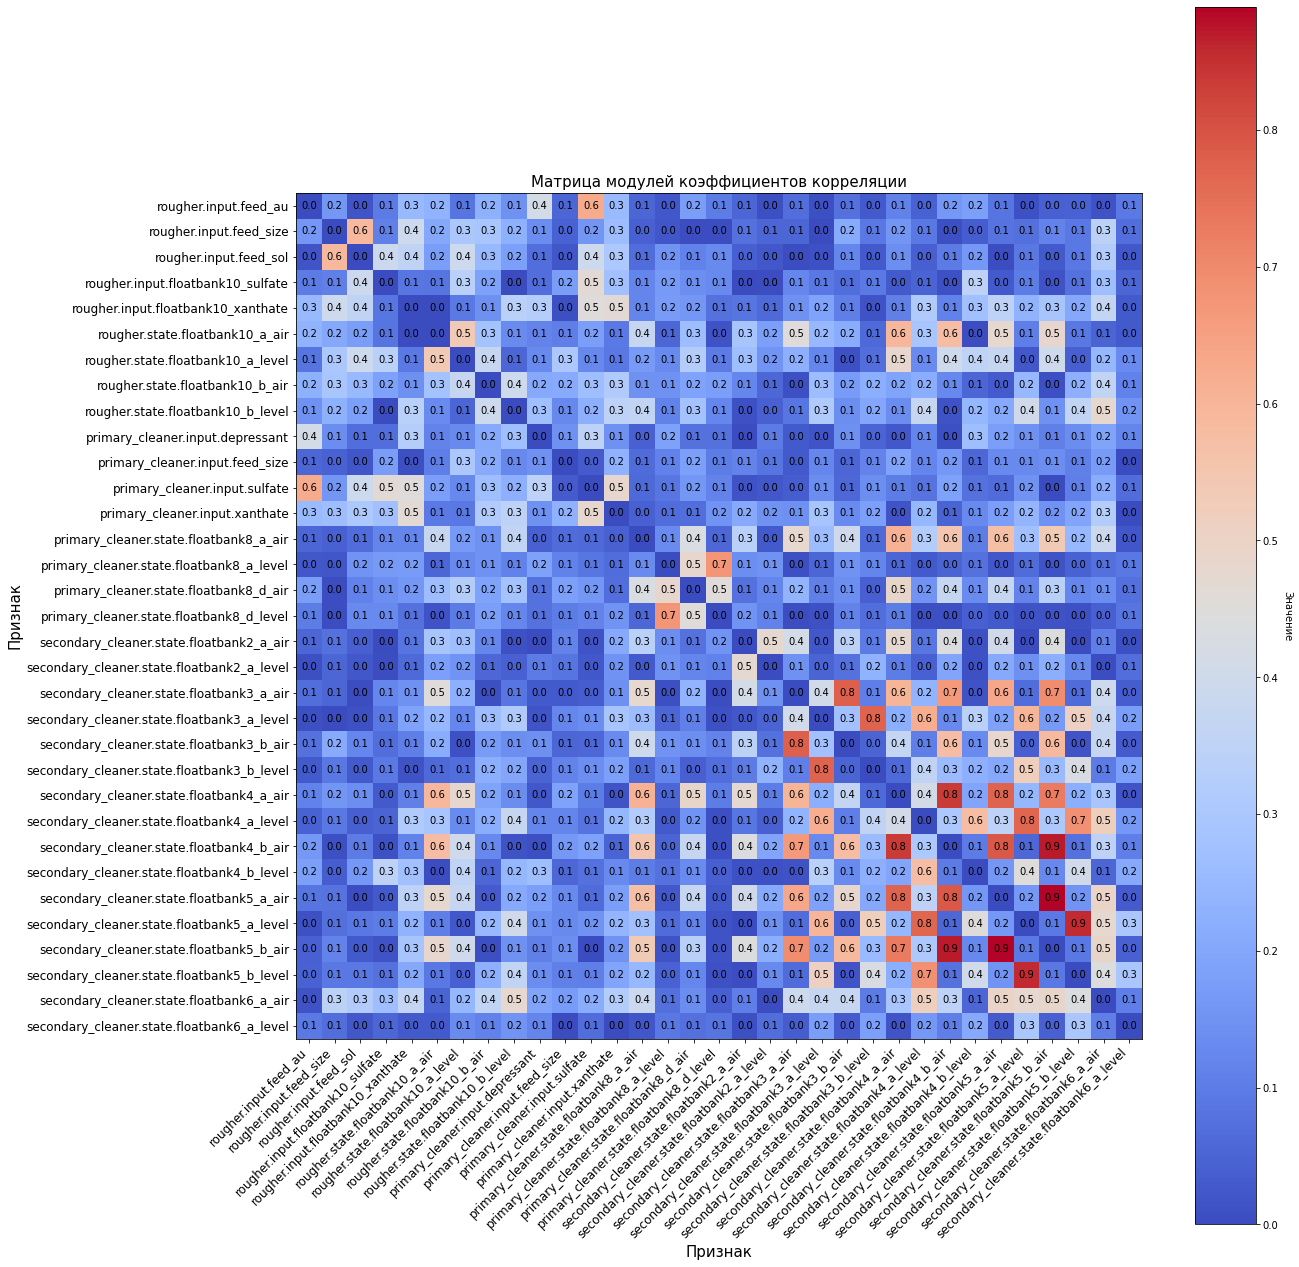

In [102]:
# Печать тепловой карты корреляции для матрицы корреляции признаков X_train
print_corr_heatmap(X_train.corr(), (19,19))

In [103]:
# Вывод топовых коррелирующих признаков на основе матрицы корреляции признаков X_train
print_top_corr_features(X_train.corr())

Признаки с наибольшими коэффициентами корреляции:


,Обучающая_выборка,Тестовая_выборка,Коэффициент_корреляции
0,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_b_air,0.889977
1,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_a_air,0.889977
2,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank5_b_air,0.871822
3,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank4_b_air,0.871822
4,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_level,0.855436
5,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank5_a_level,0.855436
6,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_b_air,0.837362
7,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_a_air,0.837362
8,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank4_b_air,0.791415
9,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank5_a_air,0.791415


In [104]:
# Создаем экземпляр модели линейной регрессии
model_lr = LinearRegression()

# Задание параметров для поиска по сетке
params_lr = {
    'model__fit_intercept': [True, False],# Определяет, следует ли включать интерсепт (свободный член) в модель
    'model__normalize': [True, False],    # Определяет, следует ли нормализовать входные данные перед обучением модели
    'model__copy_X': [True, False],       # Определяет, следует ли создавать копию входных данных перед обучением модели
}

In [105]:
# Создание объекта GridSearchCV для поиска по сетке
grid_search_lr = GridSearchCV(
    estimator=Pipeline(transform_steps + [('model', model_lr)]),  # Создаем конвейер с преобразованиями и моделью
    param_grid=params_lr,  # Задаем сетку параметров для перебора
    cv=30,  # Количество кросс-валидационных разбиений
    scoring=scoring  # Метрика оценки качества модели
)

In [106]:
%%time

# Запускаем решетчатый поиск для нахождения наилучших параметров модели
grid_search_lr.fit(X_train, Y_train.values.ravel())

# Выводим оценки качества модели
print_scores(grid_search_lr, params_lr)

Наилучшие параметры:
	model__copy_X: True
	model__fit_intercept: True
	model__normalize: True
Наилучшее значение метрики SMAPE: 7.257
CPU times: user 32.3 s, sys: 43.3 s, total: 1min 15s
Wall time: 1min 16s


**Наилучшим значением метрики sMAPE линейной регрессии на этапе обучения является значение 7.26**

# Градиентный бустинг для задачи регрессии (LGBMRegressor)

In [107]:
# Создание объекта модели LGBMRegressor
model_LGBMR = LGBMRegressor(
    random_state=random_state,
#     device = 'gpu'
)

# Задание параметров для поиска по сетке
params_LGBMR = {
    'model__boosting_type': ['gbdt', 'dart'],  # Тип градиентного бустинга
    'model__num_leaves': [20, 30, 40, 50, 60],  # Количество листьев в деревьях
    'model__learning_rate': [0.1, 0.05, 0.01],  # Скорость обучения
    'model__n_estimators': [100, 200, 300, 400, 500],  # Количество деревьев
    'model__max_depth': [-1, 10, 50],
}

In [108]:
# Создание конвейера с преобразованиями и моделью
pipeline = Pipeline(transform_steps + [('model', model_LGBMR)])

# Создание объекта GridSearchCV для поиска по сетке
grid_search_LGBMR = GridSearchCV(
    estimator=pipeline,  # Используем конвейер как оцениватель
    param_grid=params_LGBMR,  # Задаем сетку параметров для перебора
    cv=10,  # Количество кросс-валидационных разбиений
    scoring=scoring  # Метрика оценки качества модели
)

In [109]:
%%time
# Засекаем время выполнения обучения модели

# Обучение модели с помощью grid_search.fit
grid_search_LGBMR.fit(X_train, Y_train.values.ravel())

# Вывод результатов с помощью print_scores
print_scores(grid_search_LGBMR, params_LGBMR)

In [110]:
# Данные результаты получены при расчёте на ноутбуке, так как по 
# неизвестным причинам Jupyterhub не в состоянии произвести данный расчёт

# Наилучшие параметры:
# 	model__boosting_type: 'gbdt'
# 	model__learning_rate: 0.01
# 	model__max_depth: -1
# 	model__n_estimators: 500
# 	model__num_leaves: 50
# Наилучшее значение метрики SMAPE: 7.010
# Wall time: 36min 24s

**Наилучшим значением метрики sMAPE модели градиентного бустинга на этапе обучения является значение 7.01**

# Случайный лес

In [111]:
# Выделяем обучающие данные
X_train = df_train[features_final]
Y_train = df_train[target_final]

In [112]:
# Создание экземпляра модели RandomForestRegressor с указанием случайного состояния
model_rfr = RandomForestRegressor(
    n_jobs=-1, 
    random_state=random_state
)

# Задаем параметры для поиска по сетке
params_rfr = {
    'model__n_estimators': [5, 10, 20, 30, 40, 50],  # Количество деревьев в случайном лесу. Проверяются четыре значения.
    'model__max_depth': [5, 7, 10, 12, 15, 17],  # Максимальная глубина каждого дерева в случайном лесу. Проверяются три значения.
    'model__min_samples_split': [2, 3],  # Минимальное количество образцов, необходимых для разделения узла. Проверяются два значения.
    'model__min_samples_leaf': [1, 2, 3],  # Минимальное количество образцов, необходимых для формирования листа. Проверяются три значения.
    'model__max_features': ['auto', 'sqrt']  # Количество признаков, рассматриваемых при каждом делении. Проверяются два значения.
}

In [113]:
# Создаем пайплайн с преобразованиями и моделью
pipeline = Pipeline(steps=transform_steps + [('model', model_rfr)])

# Создаем объект GridSearchCV для выполнения поиска по сетке
grid_search_rfr = GridSearchCV(
    estimator=pipeline,  # Задаем пайплайн как оцениваемую модель
    param_grid=params_rfr,  # Задание сетки параметров для перебора
    cv=30,  # Количество фолдов в кросс-валидации
    scoring=scoring,  # Метрика оценки качества модели
)

In [123]:
%%time
# Измерение времени выполнения кода

grid_search_rfr.fit(X_train, Y_train.values.ravel())
# Обучение модели с использованием сетки параметров. X_train - признаки обучающей выборки, Y_train - целевая переменная (преобразованная в одномерный массив)

print_scores(grid_search_rfr, params_rfr)
# Вывод результатов оценки качества модели с лучшими параметрами. Параметры grid_search - экземпляр класса GridSearchCV, params - сетка параметров модели

In [115]:
# Данные результаты получены при расчёте на ноутбуке, так как по 
# неизвестным причинам Jupyterhub не в состоянии произвести данный расчёт

# Наилучшие параметры:
# 	model__max_depth: 7
# 	model__max_features: 'sqrt'
# 	model__min_samples_leaf: 3
# 	model__min_samples_split: 3
# 	model__n_estimators: 30
# Наилучшее значение метрики SMAPE: 6.643
# Wall time: 21min 51s

**Наилучшим значением метрики sMAPE модели случайного леса на этапе обучения является значение 6.64**

# Решающее дерево

In [116]:
# Создаем объект модели DecisionTreeRegressor с заданным random_state
model_dtr = DecisionTreeRegressor( 
    random_state=random_state
)

params_dtr = {
    'model__max_depth': [5, 7, 10, 15, 20, 25],  # Максимальная глубина дерева
    'model__min_samples_split': [2, 3, 4, 5, 6], # Минимальное количество образцов, необходимых для разделения узла
    'model__min_samples_leaf': [1, 2, 3, 4, 5],  # Минимальное количество образцов, необходимых для листового узла
    'model__max_features': ['auto', 'sqrt', 'log2']
}

In [117]:
grid_search_dtr = GridSearchCV(
        estimator=Pipeline(transform_steps + [('model', model_dtr)]),  # Создание конвейера, включающего преобразования данных и модель решающего дерева
        param_grid=params_dtr,  # Установка сетки параметров для перебора
        cv=35,  # Число фолдов для кросс-валидации
        scoring=scoring,  # Метрика оценки модели
#         verbose=1  # Вывод дополнительной информации о процессе выполнения
    )

In [118]:
%%time

grid_search_dtr.fit(X_train, Y_train.values.ravel())  # Обучение GridSearchCV на обучающих данных

print_scores(grid_search_dtr, params_dtr)  # Вывод результатов оценки модели с помощью функции print_scores

In [119]:
# Данные результаты получены при расчёте на ноутбуке, так как по 
# неизвестным причинам Jupyterhub не в состоянии произвести данный расчёт

# Наилучшие параметры:
# 	model__max_depth: 5
# 	model__max_features: 'log2'
# 	model__min_samples_leaf: 2
# 	model__min_samples_split: 2
# Наилучшее значение метрики SMAPE: 7.414
# Wall time: 39min 1s

**Наилучшим значением метрики sMAPE модели решающего дерева на этапе обучения является значение 7.41**

# CatBoost

Определим параметры модели CatBoostRegressor

In [120]:
model_cbr = CatBoostRegressor(
    verbose=20000,  # Уровень вывода информации во время обучения модели (100 - вывод каждые 100 итераций)
    eval_metric=SMAPEMetric(),  # Используемая метрика для оценки модели (SMAPEMetric - симметричное среднее абсолютное процентное отклонение)
    task_type="CPU",  # Тип задачи (используется процессор)
    iterations=20000,  # Количество итераций обучения модели
)

In [121]:
%%time

# Обучение модели
model_cbr.fit(
    df_train[features_final], df_train[target_final],
);

Learning rate set to 0.005114
0:	learn: 7.9717755	total: 249ms	remaining: 1h 22m 50s
19999:	learn: 2.2619152	total: 5m 14s	remaining: 0us
CPU times: user 5min 14s, sys: 3.35 s, total: 5min 17s
Wall time: 5min 32s


In [127]:
%%time

# Рассчет метрики sMAPE на кросс-валидации
print('Значение метрики sMAPE на кросс-валидации:', 
      cross_val_score(
          model_cbr, 
          df_train[features_final], 
          df_train[target_final].values.ravel(), 
          cv=30, 
          scoring=scoring).mean()
     )

In [129]:
# Данные результаты получены при расчёте на ноутбуке, так как по 
# неизвестным причинам Jupyterhub не в состоянии произвести данный расчёт

# Значение метрики sMAPE на кросс-валидации: -6.734339119776819
# Wall time: 53min 21s

**Наилучшим значением метрики sMAPE градиентного бустинга на этапе обучения является значение -6.73**

На этапе обучения самые лучшие показатели метрики sMAPE у случайного леса - 6.64 и градиентного бустинга (CatBoost) - 3.98. Однако все иные модели также демонстрируют близкие показатели:
1. Случайный лес - 6.64;
2. Градиентный бустинг (CatBoost) - -6.73;
3. Градиентный бустинг для задачи регрессии (LGBMRegressor) - 7.01;
4. Линейная регрессия - 7.26;
5. Решающее дерево - 7.41.

Так как результаты показателя метрики sMAPE у случайного леса и градиентного бустинга (CatBoost) близки, то сделаем предсказания на тестовых признаках и вычислим метрику sMAPE rougher.output.recovery используя обе модели

In [124]:
# Выделение тестовых данных для финального этапа из тестового датасета
X_test = df_test[features_final]

# Выделение целевого признака для финального этапа из тестового датасета
Y_test = df_test[target_final]

###### Модель случайный лес

In [125]:
# Вычисление и вывод метрик для тестовой выборки
print_scores_on_test(grid_search, params, X_test, Y_test.values.ravel())

In [130]:
# Данные результаты получены при расчёте на ноутбуке, так как по 
# неизвестным причинам Jupyterhub не в состоянии произвести данный расчёт

# Параметры модели:
# 	model__max_depth: 5
# 	model__max_features: 'log2'
# 	model__min_samples_leaf: 2
# 	model__min_samples_split: 2
# Значение метрики sMAPE на тестовых данных: 7.966909099208877

###### Модель градиентный бустинг (CatBoost)

In [126]:
# Получаем предсказанные значения целевой переменной на тестовых данных
Y_predicted = model_cbr.predict(X_test)

# Выводим значение метрики sMAPE на тестовых данных
print('Значение метрики sMAPE на тестовых данных:', , smape(Y_test.values.ravel(), Y_predicted))

In [131]:
# Данные результаты получены при расчёте на ноутбуке, так как по 
# неизвестным причинам Jupyterhub не в состоянии произвести данный расчёт

# Значение метрики sMAPE на тестовых данных: 6.229074277011311

**Наилучшим значением метрики sMAPE у модели градиентного бустинга (CatBoost) на тестовых данных - 6.23 в то время как значение метрики sMAPE у модели случайный лес - 7.97, что существенно хуже.**

###### Проверка на адекватность

Для проверки моделей на адекватность в качестве базовой (dummy-модели) возьмем модель, заполняющая целевой признак медианой целевого признака обучающей выборки.

In [137]:
# Создание объекта DummyClassifier с стратегией "constant" и константным значением, равным медиане целевой переменной
dummy_classifier = DummyClassifier(random_state=random_state, constant=Y_train.median())

# Обучение модели на обучающих данных
dummy_classifier.fit(X_train, Y_train)

# Вычисление и вывод значения метрики sMAPE на тестовых данных с использованием DummyClassifier
print('Значение dummy метрики sMAPE на тестовых данных:', smape(Y_test.values.ravel(), dummy_classifier.predict(X_test)))

Значение dummy метрики sMAPE на тестовых данных: 38.847549747910776


Полученное значение хуже значений метрики sMAPE всех прочих моделей.

###### Выводы
Наилучшие значения метрики sMAPE 6.23 на тестовых данных получено с помощью градиентного бустинга (CatBoost).

In [1]:
# Указание значения sMAPE для финальной модели
sMAPE_final = 6.23

In [139]:
# Печать итогового значения метрики sMAPE на тестовых данных
print('Итоговое значение метрики sMAPE на тестовых данных:', smape_total(sMAPE_rougher, sMAPE_final))

Итоговое значение метрики sMAPE на тестовых данных: 5.4625


In [141]:
# Печать итогового значения dummy метрики sMAPE на тестовых данных
print('Итоговое значение dummy метрики sMAPE на тестовых данных:', smape_total(6.43, 38.85))

Итоговое значение dummy метрики sMAPE на тестовых данных: 30.745000000000005


###### Выводы

На этапе обучения и проверки моделей выполнены следующие шаги:
- подготовлен тестовый набор данных
- подготовлены функции расчета метрики sMAPE
- проведено независимое обучение моделей предсказания эффективности обогащения чернового и финального концентратов

По результатам проверки моделей на тестовой выборке получены следующие результаты:
- для модели предсказания эффективности обогащения чернового концентрата:
    - наилучшее значение метрики sMAPE (3.07) получено с помощью градиентного бустинга (CatBoost)

- для модели предсказания эффективности обогащения чернового концентрата:
    - наилучшие значения метрики sMAPE 6.23 на тестовых данных получено с помощью градиентного бустинга 

Итоговое значение метрики sMAPE на тестовых данных - 6.23 (для dummy-модели 38.85)

В целом следует отметить, что применение модели линейной регрессии представляется также достаточно эффективным, поскольку:
- значения целевой метрики на тестовой выборке близко к наилучшему 
- время обучения минимальное
- возможна простая интерпретация значимости обучающих признаков 

# Выводы

Исследование проводилось в интересах компании «Цифры», разрабатывающей решения для эффективной работы промышленных предприятий. В рамках исследования изучен технологический процесс восстановления золота из золотосодержащей руды и подготовлены прототипы моделей машинного обучения для оценки эффективности обогащения чернового и финального концентратов.

Исходные данные исследования представлены в трех файлах:
- обучающая выборка
- тестовая выборка
- исходные данные (полный объем)

По результатам оценки состава признаков обучающей и тестовой выборки восстановлена расширенная схема технологического процесса, а также определены целевые и возможные наборы обучающих признаков.

Задачей исследования являлось построение прогноза двух величин:

- эффективность обогащения чернового концентрата `rougher.output.recovery`
- эффективность обогащения финального концентрата `final.output.recovery`

1. На этапе подготовки и предварительной обработки данных выполнен расчет указанных величин с целью проверки. С учетом имеющегося описания технологического процесса, а также по результатам выполненной проверки сделаны следующие выводы:
  - этап флотации является независимым, модель оценки эффективности обогащения чернового концентрата `rougher.output.recovery` можно построить только на параметрах этапа флотации
  - финальный этап вероятно зависит от всех предыдущих, модель оценки эффективности обогащения финального концентрата `final.output.recovery` следует строить на всех входных параметрах (параметров сырья и этапов) предыдущих этапов - это следует как минимум из того, что параметр `rougher.input.feed_au` применяется при расчете оценки эффективности обогащения финального концентрата  
  
Также на этапе подготовки и предварительной обработки данных выполнена процедура заполнения пропусков в данных на основе средних значений ближайших данных, а также выполнена оценка корреляции обучающих признаков (учитывалась при формировании обучающих признаков моделей линейной регрессии).

2. На этапе анализа данных получены следующие результаты:
- **Динамика концентраций металлов:**
    - Концентрация золота ожидаемо последовательно увеличивается от этапа к этапу.
    - Концентрация серебра уменьшается от этапа к этапу, что говорит о том, что значительную долю примесей в исходной руде составляет именно серебро.
    - Концентрация свинца наименьшая на этапе флотации, на этапах первичной и финальной очистки концентрация практически одинакова. На финальном этапе распределение концентрации свинца становится более компактным.

- **Суммарная концентрация веществ:**
    - Распределение суммарной концентрации веществ становится более компактным от этапа к этапу.

- **Размеры гранул:**
    - Вид и форма распределений одинаковы, численные характеристики отличаются (среднее, дисперсия). Целесообразно к признакам размеров гранул сырья применить стандартизацию, поскольку по условиям признак является значимым, а область определения на тестовой выборке не пересекается с обучающей.

Имевшиеся в данных аномалии в распределениях концентрации металлов и размеров гранул удалены с целью последующего обучения моделей.

3. На этапе обучения и проверки моделей проведено независимое обучение моделей предсказания эффективности обогащения чернового и финального концентратов.

По результатам проверки моделей на тестовой выборке получены следующие результаты:
- **Для модели предсказания эффективности обогащения чернового концентрата:**
    - Наилучшее значение метрики sMAPE (3.07) получено с помощью градиентного бустинга (CatBoost).

- **Для модели предсказания эффективности обогащения чернового концентрата:**
    - наилучшие значения метрики sMAPE 6.23 на тестовых данных получено с помощью градиентного бустинга (CatBoost) 
    
Итоговое значение метрики sMAPE на тестовых данных - 6.23 (для dummy-модели 38.85).

В целом следует отметить, что применение модели линейной регрессии представляется наиболее эффективным, поскольку:
- Значения целевой метрики на тестовой выборке являются наилучшими.
- Время обучения минимальное.
- Возможна простая интерпретация значимости обучающих признаков.

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке